# Load Packages and set plotting defaults

In [1]:
# load packages
import numpy as np
import itertools
import json
import time
import pandas as pd
import glob
from copy import deepcopy
import os
import sys
from joblib import Parallel, delayed, cpu_count, dump,load

import plotly.express as px
import plotly.graph_objs as go
import plotly
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors

import pingouin
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy


from zpyhelper.filesys import checkdir
from zpyhelper.MVPA.rdm import compute_rdm,lower_tri,upper_tri, compute_rdm_nomial, compute_rdm_identity
from zpyhelper.MVPA.preprocessors import scale_feature, split_data, concat_data
from zpyhelper.MVPA.estimators import PatternCorrelation, MultipleRDMRegression

project_path = r'E:\pirate_fmri\Analysis'
sys.path.append(project_path)
from scripts.Exp1_fmri.multivariate.modelrdms import ModelRDM
from scripts.Exp1_fmri.multivariate.pirateOMutils import parallel_axes_cosine_sim, minmax_scale, generate_filters
from src.utils.stats import ttest1samp_equiv_permutation, ttestindsamp_equiv_permutation, ttestpairedsamp_equiv_permutation, correlation_equiv_permutation, compute_se
from plotting_utils import plot_rdm_withlabel, grouped_barscatter_withstats,gen_pval_annot

import warnings

warnings.simplefilter('ignore', category=FutureWarning)

In [2]:
# load data
study_scripts   = os.path.join(project_path,"scripts","Exp1_fmri")
with open(os.path.join(study_scripts,'pirate_defaults.json')) as f:
    pirate_defaults = json.load(f)
    subid_list = pirate_defaults['participants']['validids']
    cohort1ids = [x for x in pirate_defaults['participants']['cohort1ids'] if x in subid_list]
    cohort2ids = [x for x in pirate_defaults['participants']['cohort2ids'] if x in subid_list]
    nongeneralizers = pirate_defaults['participants']["nongeneralizerids"]
    generalizers    = pirate_defaults['participants']["generalizerids"]

print("N_cohort 1: ",len(cohort1ids), "  N_cohort 2: ",len(cohort2ids), "N_Total: ",len(subid_list))

ROIRSAdir =  os.path.join(project_path,"data","Exp1_fmri", "fmri", "ROIdata")
roi_data = load(os.path.join(ROIRSAdir,"roi_data_4r.pkl"))
rois =  list(roi_data.keys())
roi_shortnames = dict(zip(
    rois,
    [roi.split("_")[0] for roi in rois]
))
print("ROIs: " , roi_shortnames)

N_cohort 1:  29   N_cohort 2:  27 N_Total:  56
ROIs:  {'PPC_bilateral': 'PPC', 'HPC_bilateral': 'HPC', 'vmPFC_bilateral': 'vmPFC', 'V1_bilateral': 'V1'}


In [48]:
# plotting palettes
choose_color_from = sns.color_palette("colorblind",10).as_hex()


# groundtruth maps
train_test_color_pal = dict(zip(["Training Stimuli","Test Stimuli"],[choose_color_from[0],choose_color_from[1]]))
axis_group_markers = dict(zip(["x","y"],["o","D"]))

#replace the central one that was actually used in the task('#8484FF') 
#with the color palette for training stimuli for easy understanding
stimycolorhex = dict(zip(
    [-2,-1,0,1,2],
    ['#FFD300', '#005800', choose_color_from[0], '#9E4F46', '#00FFC1'] 
))
stimxanimalnames = dict(zip(
    [-2,-1,0,1,2],
    ["crab","duck","elephant","giraffe","whale"]

))


# Dimensionality
high_lowD_colors = [choose_color_from[4],choose_color_from[-1]]
high_lowD_colors


# Participants
participantgrouphex = dict(zip(
    ["Generalizer","nonGeneralizer"],
    [choose_color_from[2],choose_color_from[4]]  
))

psgroup_huedict = dict(zip(["top-right","orthogonal","top-left"],
                           #["#15B01A","#BF9000","#030764"],# GREEN, yellow, darkblue
                           [choose_color_from[5],choose_color_from[7],choose_color_from[8]]
                           )) 
psgroupnum_huedict = dict(zip([-1,0,1],
                           #["#15B01A","#BF9000","#030764"],# GREEN, yellow, darkblue
                           [choose_color_from[5],choose_color_from[7],choose_color_from[8]]
                           )) 


print("stimycolorhex: ", stimycolorhex)
print("participantgrouphex: ", participantgrouphex)
print("axis_group_markers: ", axis_group_markers)
print("psgroup_huedict: ", psgroup_huedict)
print("psgroupnum_huedict: ", psgroupnum_huedict)
print("train_test_color_pal: ", train_test_color_pal)


stimycolorhex:  {-2: '#FFD300', -1: '#005800', 0: '#0173b2', 1: '#9E4F46', 2: '#00FFC1'}
participantgrouphex:  {'Generalizer': '#029e73', 'nonGeneralizer': '#cc78bc'}
axis_group_markers:  {'x': 'o', 'y': 'D'}
psgroup_huedict:  {'top-right': '#ca9161', 'orthogonal': '#949494', 'top-left': '#ece133'}
psgroupnum_huedict:  {-1: '#ca9161', 0: '#949494', 1: '#ece133'}
train_test_color_pal:  {'Training Stimuli': '#0173b2', 'Test Stimuli': '#de8f05'}


In [4]:
# plotting markers
from svgpath2mpl import parse_path
from matplotlib.path import Path
from xml.dom import minidom
from matplotlib.transforms import Affine2D

# Function to extract path data from an SVG file
def extract_svg_path(svg_file):
    doc = minidom.parse(svg_file)
    path_strings = [path.getAttribute('d') for path in doc.getElementsByTagName('path')]
    doc.unlink()
    return path_strings  # Assuming there's only one path in the SVG file

# Load the SVG file and extract the path data
svg_folder = r'D:\OneDrive - Nexus365\pirate_ongoing\animalsvg'
stimxanimalmarkers = {}
for xloc,animal in stimxanimalnames.items():
    svg_file = os.path.join(svg_folder, f'{animal}.svg')
    svg_path_strings = extract_svg_path(svg_file)
    # Convert the SVG path to a Matplotlib path
    custom_markers = [parse_path(svg_path_string) for svg_path_string in svg_path_strings]
    
    for marker in custom_markers:
       marker.vertices -= marker.vertices.mean(axis=0)  # Center the marker
       
    stimxanimalmarkers[xloc] = Path(
                                    np.vstack([m.vertices for m in custom_markers]),
                                    np.hstack([m.codes for m in custom_markers])
                               ).transformed(Affine2D().scale(1, -1))

svg_file = os.path.join(svg_folder, f'pirate.svg')
svg_path_strings = extract_svg_path(svg_file)
# Convert the SVG path to a Matplotlib path
custom_markers = [parse_path(svg_path_string) for svg_path_string in svg_path_strings]

for marker in custom_markers:
    marker.vertices -= marker.vertices.mean(axis=0)  # Center the marker
    
piratemarkers = Path(           np.vstack([m.vertices for m in custom_markers]),
                                np.hstack([m.codes for m in custom_markers])
                            ).transformed(Affine2D().scale(1, -1))


In [5]:
# font settings
def_font_axis_legend_titles = {"fontsize":12,"fontweight":"bold"}
def_font_axis_tick_labels = {"fontsize":10,"fontweight":"regular"}
def_font_subplot_titles = {"fontsize":16,"fontweight":"bold"}

In [6]:
# handy functions
minmax_scale_anyD = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

descriptive_stats_dict = {
    "mean": np.mean,
    "se": compute_se,
    "std": np.std,
    "n": lambda x: len(x)
}
descriptive_stats = ['mean',compute_se,'count','std']

# Dimensionality

Plots related to dimensionality (Figure 2 of the main text). Make sure that the [`computeCVSVDdim_withinaxis.py`](multivariate/computeCVSVDdim_withinaxis.py) and [`decoding_trainingstim.py`](multivariate/decoding_trainingstim.py) have been executed before running the plotting scripts in this section.

## Load results

In [50]:

# dimensionality estimates
svdestdim_df = pd.read_csv(os.path.join(ROIRSAdir,'cvSVD_dimsionality',"trainingstim_withinax_svdestdim_df.csv"))

svdestdim_df = svdestdim_df[svdestdim_df.roi.isin(rois)]    
svdestdim_df["roi"] = pd.Categorical(svdestdim_df.roi, categories=rois,ordered=True)
svdestdim_df_sum = svdestdim_df.groupby(["roi","subid","dimonaxis"]).mean().reset_index()
svdestdim_df_sum[["region","side"]] = svdestdim_df_sum.roi.str.split("_",expand=True)
svdestdim_df_sum["subgroup"] = ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in svdestdim_df_sum["subid"]]    
svdestdim_df_sum["subcohort"] = ["first cohort" if subid in cohort1ids else "second cohort" for subid in svdestdim_df_sum["subid"]] 

# svd projection
svdprojection_df = pd.read_csv(os.path.join(ROIRSAdir,"cvSVD_dimsionality","trainingstim_withinax_meanXsvd1Dproj_df.csv"))

svdprojection_df_sum = svdprojection_df.groupby(["roi","subid","dimonaxis","axisloc"]).mean().reset_index()

svdprojection_df["subgroup"] = ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in svdprojection_df["subid"]]
svdprojection_df["subcohort"] = ["first cohort" if subid in cohort1ids else "second cohort" for subid in svdprojection_df["subid"]]
svdprojection_df["roi"] = pd.Categorical(svdprojection_df.roi, categories=rois,ordered=True)

svdprojection_df_sum["subgroup"] = ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in svdprojection_df_sum["subid"]]
svdprojection_df_sum["subcohort"] = ["first cohort" if subid in cohort1ids else "second cohort" for subid in svdprojection_df_sum["subid"]] 
svdprojection_df_sum["roi"] = pd.Categorical(svdprojection_df_sum.roi, categories=rois,ordered=True)


# decoding
nctrstim_decoding_res = load(os.path.join(ROIRSAdir,"trainingstim_decoding_results","noncenter_trainingstim_LRdecoding_acc_skf.pkl"))
nctrstimdc_performance_df = nctrstim_decoding_res["performance"].copy()
nctrstimdc_performance_dfsum = nctrstimdc_performance_df.groupby(["roi","subid","target"])[["fit_acc","eval_acc"]].mean().reset_index()

nctrstimdc_performance_dfsum["subgroup"] = pd.Categorical(
    ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in nctrstimdc_performance_dfsum["subid"]],
    categories=["Generalizer","nonGeneralizer"],ordered=True
)
nctrstimdc_performance_dfsum[['region','side']] = nctrstimdc_performance_dfsum.roi.str.split("_",expand=True)
#
nctrstimdc_performance_df["subgroup"] = ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in nctrstimdc_performance_df["subid"]]
nctrstimdc_performance_df[['region','side']] = nctrstimdc_performance_df.roi.str.split("_",expand=True)

# merge dataframe for correlation
# correlation between decoding accuracy and dimensionality separately for each axis
nctrstimdc_performance_dfsum["target"] = pd.Categorical(nctrstimdc_performance_dfsum["target"],categories=["stim_id","stim_x","stim_y"],ordered=True)

training_feature_decoding = nctrstimdc_performance_df.query("target!='stim_id'").groupby(["roi","subid","target"])[["fit_acc","eval_acc"]].mean().reset_index()
training_feature_decoding["dimonaxis"] = training_feature_decoding["target"].map(dict(zip(['stim_x', 'stim_y'], ['x axis', 'y axis'])))
training_feature_decoding = training_feature_decoding.join(svdestdim_df_sum.set_index(["roi","subid","dimonaxis"]),on=["roi","subid","dimonaxis"],rsuffix="_svd")


## Stats

### 1. sanity checks to see if:  
   (1) x- and y-axis estimates are different  
   (2) x- and y-axis estimates are correlated  

In [51]:
# sanity checks
svdestdim_df_sum_wide = svdestdim_df_sum.pivot(index=["roi","subid","subgroup"],columns="dimonaxis",values="est_dim").reset_index()
xydimpaired = pd.DataFrame()
for roiname, roidf in svdestdim_df_sum_wide[(svdestdim_df_sum_wide.subgroup=="Generalizer")].copy().groupby("roi"):
    print(roiname)
    xycorr=correlation_equiv_permutation(roidf["x axis"].values,roidf["y axis"].values,
                                        corrfun=lambda x,y: scipy.stats.pearsonr(x,y).statistic,
                                        return_ponly=False)
    xydiff=ttestpairedsamp_equiv_permutation(roidf["y axis"].values,roidf["x axis"].values,
                                        return_ponly=False)
    xydimpaired = pd.concat([xydimpaired,
                             pd.DataFrame({"test":["corr","diff"],
                                           "teststat":[xycorr.statistic, xydiff.statistic],
                                           "pval":[xycorr.pvalue, xydiff.pvalue]
                                           }).assign(roi=roiname,subgroup="Generalizers")
                                           ],
                             ignore_index=True)    

for roiname, roidf in svdestdim_df_sum_wide[(svdestdim_df_sum_wide.subgroup=="nonGeneralizer")].copy().groupby("roi"):
    print(roiname)
    xycorr=correlation_equiv_permutation(roidf["x axis"].values,roidf["y axis"].values,
                                        corrfun=lambda x,y: scipy.stats.pearsonr(x,y).statistic,
                                        return_ponly=False)
    xydiff=ttestpairedsamp_equiv_permutation(roidf["y axis"].values,roidf["x axis"].values,
                                        return_ponly=False)
    xydimpaired = pd.concat([xydimpaired,
                             pd.DataFrame({"test":["corr","diff"],
                                           "teststat":[xycorr.statistic, xydiff.statistic],
                                           "pval":[xycorr.pvalue, xydiff.pvalue]
                                           }).assign(roi=roiname,subgroup="nonGeneralizers")
                                           ],
                             ignore_index=True)    
xydimpaired.to_csv(os.path.join(ROIRSAdir,'cvSVD_dimsionality',"xyestdim_paired.csv"),index=False)

PPC_bilateral
HPC_bilateral
vmPFC_bilateral
V1_bilateral
PPC_bilateral
HPC_bilateral
vmPFC_bilateral
V1_bilateral


### 2. descriptive statistics and sanity check on reconstruction correlation (should be larger than zero)

In [52]:
svd_descriptive_by_axis_dfs = []
for gnames, gdf in svdestdim_df_sum.groupby(["roi","dimonaxis"]):
    print(gnames)
    for yvars in ["est_dim","reconstruction_corr"]:
        ydata = gdf[yvars]
        tmpdf = pd.DataFrame({"roi": gnames[0], "dimonaxis": gnames[1], "metric":yvars, "subgroup": "All Participants"},index=[0])
        
        tmpdf["mean"] = ydata.mean()
        tmpdf["se"] = compute_se(ydata)
        tmpdf["n"] = ydata.count()

        if yvars == "reconstruction_corr":
            permtestres = ttest1samp_equiv_permutation(ydata.values,n_perm=10000,return_ponly=False)
            tmpdf["permtest_p"] =  permtestres.pvalue
            tmpdf["permtest_teststat"] = permtestres.statistic
        else:
            tmpdf["permtest_p"] =  np.nan
            tmpdf["permtest_teststat"] = np.nan

        svd_descriptive_by_axis_dfs.append(tmpdf)

        for sg,sgdf in gdf.groupby("subgroup"):
            print(sg)
            ydata = sgdf[yvars]
            tmpdf = pd.DataFrame({"roi": gnames[0], "dimonaxis": gnames[1], "metric":yvars, "subgroup": sg},index=[0])
            
            tmpdf["mean"] = ydata.mean()
            tmpdf["se"] = compute_se(ydata)
            tmpdf["n"] = ydata.count()

            if yvars == "reconstruction_corr":
                permtestres = ttest1samp_equiv_permutation(ydata.values,n_perm=10000,return_ponly=False)
                tmpdf["permtest_p"] =  permtestres.pvalue
                tmpdf["permtest_teststat"] = permtestres.statistic
            else:
                tmpdf["permtest_p"] =  np.nan
                tmpdf["permtest_teststat"] = np.nan

            svd_descriptive_by_axis_dfs.append(tmpdf)

    tmpdf = pd.DataFrame({"roi": gnames[0], "dimonaxis": gnames[1], "metric":yvars, "subgroup": "GminNG"},index=[0])
    
    Gdata = gdf[gdf.subgroup=="Generalizer"][yvars]
    NGdata = gdf[gdf.subgroup=="nonGeneralizer"][yvars]
    tmpdf["mean"] = Gdata.mean() - NGdata.mean()
    tmpdf["se"] = compute_se(Gdata,NGdata)
    tmpdf["n"] = Gdata.count() + NGdata.count()

    permtestres = ttestindsamp_equiv_permutation(Gdata.values,NGdata.values,n_perm=10000,return_ponly=False)
    tmpdf["permtest_p"] =  permtestres.pvalue
    tmpdf["permtest_teststat"] = permtestres.statistic
    svd_descriptive_by_axis_dfs.append(tmpdf)

svd_descriptive_by_axis_df = pd.concat(svd_descriptive_by_axis_dfs,ignore_index=True)
svd_descriptive_by_axis_df.to_csv(os.path.join(ROIRSAdir,'cvSVD_dimsionality',"svdstats_byaxis_df.csv"),index=False)

('PPC_bilateral', 'x axis')
Generalizer
nonGeneralizer
Generalizer
nonGeneralizer
('PPC_bilateral', 'y axis')
Generalizer
nonGeneralizer
Generalizer
nonGeneralizer
('HPC_bilateral', 'x axis')
Generalizer
nonGeneralizer
Generalizer
nonGeneralizer
('HPC_bilateral', 'y axis')
Generalizer
nonGeneralizer
Generalizer
nonGeneralizer
('vmPFC_bilateral', 'x axis')
Generalizer
nonGeneralizer
Generalizer
nonGeneralizer
('vmPFC_bilateral', 'y axis')
Generalizer
nonGeneralizer
Generalizer
nonGeneralizer
('V1_bilateral', 'x axis')
Generalizer
nonGeneralizer
Generalizer
nonGeneralizer
('V1_bilateral', 'y axis')
Generalizer
nonGeneralizer
Generalizer
nonGeneralizer


### 3. compare mean dimensionality estimates between regions

In [53]:
svdestdim_df_sum_overaxis = svdestdim_df_sum.groupby(["roi","subid"])[["est_dim","reconstruction_corr"]].mean().reset_index()
svdestdim_df_sum_overaxis["subgroup"] = ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in svdestdim_df_sum_overaxis["subid"]]
svdestdim_df_sum_overaxis.shape
svdestdim_df_sum_overaxis.columns

Index(['roi', 'subid', 'est_dim', 'reconstruction_corr', 'subgroup'], dtype='object')

In [54]:
svd_dim_descriptive = pd.concat(
    [svdestdim_df_sum_overaxis.groupby(["subgroup","roi"])["est_dim"].agg(descriptive_stats).reset_index(),
     svdestdim_df_sum_overaxis.groupby(["roi"])["est_dim"].agg(descriptive_stats).reset_index().assign(subgroup="All")
     ]
)

svd_dim_descriptive.rename(columns={"<lambda_0>":"se"},inplace=True)
svd_dim_descriptive.to_csv(os.path.join(ROIRSAdir,'cvSVD_dimsionality',"descriptive_stats_estdim.csv"),index=False)

svd_corr_descriptive = pd.concat(
    [svdestdim_df_sum_overaxis.groupby(["subgroup","roi"])["reconstruction_corr"].agg(descriptive_stats).reset_index(),
     svdestdim_df_sum_overaxis.groupby(["roi"])["reconstruction_corr"].agg(descriptive_stats).reset_index().assign(subgroup="All")
     ]
)

svd_corr_descriptive.rename(columns={"<lambda_0>":"se"},inplace=True)
svd_corr_descriptive.to_csv(os.path.join(ROIRSAdir,'cvSVD_dimsionality',"descriptive_stats_reconstcorr.csv"),index=False)

In [55]:
svdestdim_df_sum_overaxis_wide = svdestdim_df_sum_overaxis.pivot(index=["subid","subgroup"],columns="roi",values="est_dim").reset_index()
svdestdim_df_sum_overaxis_wide



roi,subid,subgroup,PPC_bilateral,HPC_bilateral,vmPFC_bilateral,V1_bilateral
0,sub001,Generalizer,1.000,1.875,1.250,1.000
1,sub002,nonGeneralizer,1.125,1.250,1.750,1.000
2,sub003,Generalizer,1.000,1.875,1.125,1.000
3,sub004,nonGeneralizer,1.000,2.375,1.750,1.000
4,sub005,Generalizer,1.000,1.125,1.500,1.000
5,sub006,Generalizer,1.000,1.500,1.750,1.000
6,sub007,Generalizer,1.000,1.250,1.125,1.000
7,sub008,Generalizer,1.375,2.250,2.000,1.625
8,sub009,Generalizer,2.250,3.000,2.750,2.750
9,sub010,nonGeneralizer,1.875,2.125,3.000,1.375


In [56]:
HPCavedim = svdestdim_df_sum_overaxis_wide.query("subgroup=='Generalizer'")["HPC_bilateral"].values
vmPFCavedim = svdestdim_df_sum_overaxis_wide.query("subgroup=='Generalizer'")["vmPFC_bilateral"].values
V1avedim = svdestdim_df_sum_overaxis_wide.query("subgroup=='Generalizer'")["V1_bilateral"].values
SPGavedim = svdestdim_df_sum_overaxis_wide.query("subgroup=='Generalizer'")["PPC_bilateral"]

dim_pairedtest_df = pd.DataFrame(
    {"roi1":[],
     "roi2":[],
     "pval":[],
     "statistic":[]}
)
for r1,r2 in itertools.combinations(rois,2):
    print(f"\n{r1} vs {r2}")
    perm_res = ttestpairedsamp_equiv_permutation(
        svdestdim_df_sum_overaxis_wide.query("subgroup=='Generalizer'")[r1].values,
        svdestdim_df_sum_overaxis_wide.query("subgroup=='Generalizer'")[r2].values,
        return_ponly=False
    )
    print(perm_res)
    dim_pairedtest_df = pd.concat([dim_pairedtest_df,
                                   pd.DataFrame({
                                       "roi1": [roi_shortnames[r1]],
                                       "roi2": [roi_shortnames[r2]],
                                       "statistic": [perm_res.statistic],
                                       "pval": [perm_res.pvalue]
                                   })])
        
    

dim_pairedtest_df.to_csv(os.path.join(ROIRSAdir,'cvSVD_dimsionality',"pairedpermutationtest_estdim.csv"),index=False)



PPC_bilateral vs HPC_bilateral
PermutationTestResult(statistic=-0.7103658536585366, pvalue=0.00019998000199980003, null_distribution=array([ 0.19817073, -0.03353659,  0.08231707, ..., -0.1554878 ,
       -0.14939024, -0.125     ]))

PPC_bilateral vs vmPFC_bilateral
PermutationTestResult(statistic=-0.5396341463414634, pvalue=0.00019998000199980003, null_distribution=array([ 0.10670732, -0.04573171,  0.05792683, ..., -0.2652439 ,
       -0.0152439 , -0.0945122 ]))

PPC_bilateral vs V1_bilateral
PermutationTestResult(statistic=-0.01524390243902439, pvalue=0.7157284271572842, null_distribution=array([-0.03963415, -0.02134146,  0.00914634, ..., -0.06402439,
        0.00304878, -0.02743902]))

HPC_bilateral vs vmPFC_bilateral
PermutationTestResult(statistic=0.17073170731707318, pvalue=0.1311868813118688, null_distribution=array([-0.09146341, -0.01219512, -0.02439024, ..., -0.1097561 ,
        0.13414634,  0.0304878 ]))

HPC_bilateral vs V1_bilateral
PermutationTestResult(statistic=0.6951219

### 4. SVD projection onto first component

The statistical test to compare SVD projection and axis locations are performed in R using [svdproj.Rmd](svdproj.Rmd)

## Plots

### 1. distribution plots of dimensionality estimates in ROIs
Plots shown in Figure 2 a-d

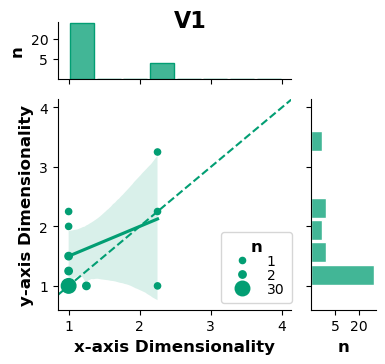

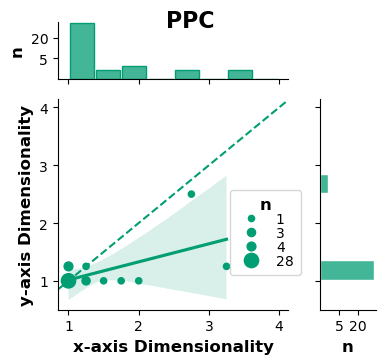

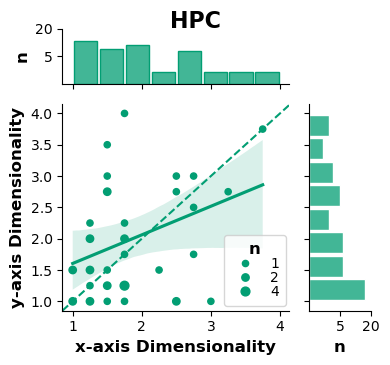

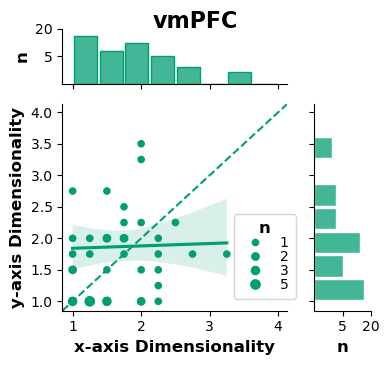

In [15]:
legendbbox = dict(zip(  
    ["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],
    [(0.85,0.4),(0.9,0.6),(0.85,0.4),(0.9,0.5)]
)
)
for ksubplot, roi in enumerate(["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"]):
    pdf = svdestdim_df_sum[(svdestdim_df_sum.subgroup=="Generalizer")&(svdestdim_df_sum.roi==roi)].copy()

    pdf_wide = pdf.pivot(index=["subid"], columns="dimonaxis", values="est_dim").reset_index()
        
    pdf_counts = pdf_wide.groupby(['x axis', 'y axis']).size().reset_index(name='counts')

    dot_color=  colors.hex2color(participantgrouphex["Generalizer"])
    gs = sns.JointGrid(data=pdf_counts, x="x axis", y="y axis",
                    marginal_ticks=True,ratio=3,space=0.,height=4)
    unique_sizes = np.sort(pdf_counts["counts"].unique())
    
    plot_sizes = np.sqrt(unique_sizes)*20
    
    sns.scatterplot(pdf_counts,
                    x="x axis",
                    y="y axis",
                    size="counts",
                    sizes=dict(zip(
                        unique_sizes,
                        plot_sizes                                
                        )), 
                    edgecolor=dot_color,facecolors=dot_color,linewidth=1,
                    ax=gs.ax_joint
                    )

    #gs.ax_joint.set_aspect(1.1)

    sns.histplot(x="x axis", 
                #linewidth=1, 
                edgecolor=dot_color,
                binrange=[1,4], bins=8, element="bars", 
                shrink=0.9, line_kws={'width':0.1}, 
                ax=gs.ax_marg_x,kde=False, color=dot_color, fill=True,
                data=pdf_wide
                )
    gs.ax_marg_x.set_yscale('function', functions=(lambda x:x**(1/2), lambda x:x**2))
    gs.ax_marg_x.set_yticks([5,20])
    gs.ax_marg_x.set_ylabel("n",fontdict=def_font_axis_legend_titles)

    sns.histplot(y="y axis", 
                #linewidth=1, 
                edgecolor="white",
                binrange=[1,4], bins=8, element="bars", 
                shrink=0.9, line_kws={'width':0.1}, 
                ax=gs.ax_marg_y,kde=False, color=dot_color, fill=True,
                data=pdf_wide)
    gs.ax_marg_y.set_xscale('function', functions=(lambda x:x**(1/2), lambda x:x**2))
    gs.ax_marg_y.set_xticks([5,20])
    gs.ax_marg_y.set_xlabel("n",fontdict=def_font_axis_legend_titles)

    handles, labels = gs.ax_joint.get_legend_handles_labels()
    for handle in handles:
        handle.set_color(dot_color)
    
    gs.ax_joint.legend(handles=handles,#[handles[1],handles[3],handles[-1]],
                    labels=labels,prop={"size":def_font_axis_tick_labels["fontsize"],"weight":def_font_axis_tick_labels["fontweight"]},
                    title="n",title_fontproperties={"size":def_font_axis_legend_titles["fontsize"],"weight":def_font_axis_legend_titles["fontweight"]},                    
                    labelspacing=0,
                    borderpad=0.5,
                    loc="upper center",bbox_to_anchor=legendbbox[roi])

    sns.regplot(data=pdf_counts, x="x axis", y="y axis",scatter=False,ax=gs.ax_joint,color=dot_color,ci=95, n_boot=10000)
    gs.ax_joint.axline((1,1),slope=1,color=dot_color,linestyle="--")

    gs.ax_joint.set_xlabel("x-axis Dimensionality",fontdict=def_font_axis_legend_titles)
    gs.ax_joint.set_ylabel("y-axis Dimensionality",fontdict=def_font_axis_legend_titles)
    gs.figure.suptitle(roi_shortnames[roi],y=0.9,**def_font_subplot_titles)
    gs.figure.tight_layout()
    plt.savefig(os.path.join(ROIRSAdir,"finalfigs",f"fig2{['a','b','c','d'][ksubplot]}.tif"),dpi=300,bbox_inches="tight")

### 2. correlation between decoding and axis
Plots shown in Figure 2 e-f


 x axis HPC_bilateral partial correlation:
rho = 0.4071, pval = 0.0010

 y axis HPC_bilateral partial correlation:
rho = 0.4120, pval = 0.0009

 x axis vmPFC_bilateral partial correlation:
rho = 0.5920, pval = 0.0000

 y axis vmPFC_bilateral partial correlation:
rho = 0.3143, pval = 0.0097


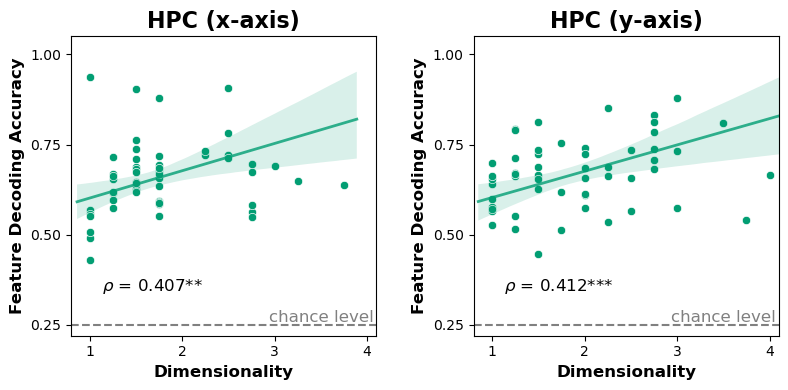

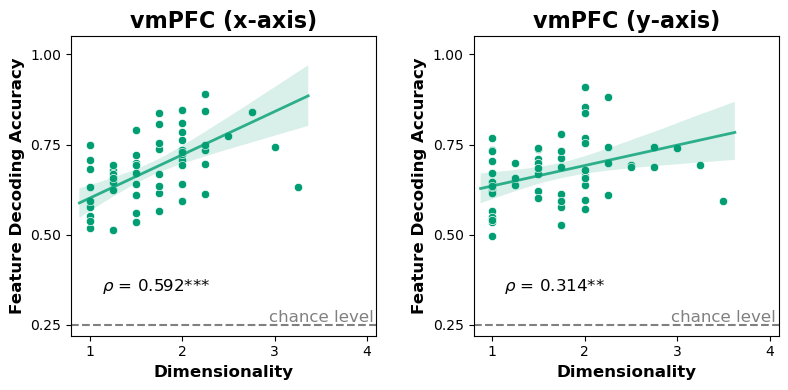

In [16]:
def partialrankcorr(data,x, y,covar, ax=None,xy=None, p_thresholds=None,**kwargs):

    res = pingouin.partial_corr(data=data, x=x,y=y,x_covar=covar,method="pearson",alternative="greater")
    rho,pval = res.r[0], res["p-val"][0]
    print(f"rho = {'%.4f' % rho}, pval = {'%.4f' % pval}")
    ax = ax if ax is not None else plt.gca()
    xy = xy if xy is not None else (0.1, 0.3)
    p_thresholds = p_thresholds if p_thresholds is isinstance(p_thresholds, float) else .05
    if pval<=p_thresholds:
        ax.annotate(r'$\rho$ = '+f'{rho:.3f}{gen_pval_annot(pval,show_pval=False)}', xy=xy, xycoords=ax.transAxes,fontsize=12)
    else:
        ax.annotate(r'$\rho$ = '+f'{rho:.3f}', xy=xy, xycoords=ax.transAxes,fontsize=12)




for jrow,roi in enumerate(["HPC_bilateral","vmPFC_bilateral"]): # "V1_bilateral","PPC_bilateral"
    fig, axes = plt.subplots(1,2,figsize=(8,4),
                         sharey=False,sharex=False)
    for kcol,dimonaxis in enumerate(["x axis","y axis"]):
        dot_color = colors.hex2color(participantgrouphex["Generalizer"])
        pdf = training_feature_decoding.query("roi==@roi & dimonaxis==@dimonaxis").copy()
        ax = axes[kcol]
        

        sns.scatterplot(data=pdf.copy(),
                        x="est_dim",y="eval_acc",
                        color=dot_color,label="Generalizer",
                        ax=ax)
        sns.regplot(data=pdf,
                    x="est_dim",y="eval_acc",
                    scatter=False,truncate=False,
                    color=dot_color,
                    line_kws={"alpha":0.8,"linewidth":2},
                    x_partial="reconstruction_corr",
                    ci=95, n_boot=10000,
                    ax=ax)
        print(f"\n {dimonaxis} {roi} partial correlation:")
        partialrankcorr(pdf,"est_dim","eval_acc","reconstruction_corr",ax=ax,xy=(.1,.15))
        ax.legend_.remove()
        
        ax.axhline(0.25,linestyle="--",color="grey")
        ax.text(3.5,.27,"chance level",color="grey",fontsize=12,ha="center",va="center")
        
        
        ax.set_title(f"{roi_shortnames[roi]} ({dimonaxis.replace(' ','-')})",fontdict=def_font_subplot_titles)   
        ax.set_ylabel("Feature Decoding Accuracy",fontdict=def_font_axis_legend_titles)
        ax.set_xlabel("Dimensionality",fontdict=def_font_axis_legend_titles)
        ax.tick_params(labelleft=True, labelbottom=True)
        ax.xaxis.label.set_visible(True)
        ax.yaxis.label.set_visible(True)

        ax.set_xlim(.8,4.1)
        ax.set_xticks([1,2,3,4])
        ax.set_ylim(0.22,1.05)
        ax.set_yticks([0.25,0.5,0.75,1])


    fig.tight_layout(w_pad=2.5,h_pad=2)  
    plt.savefig(os.path.join(ROIRSAdir,"finalfigs",f"fig2{['e','f'][jrow]}.tif"),dpi=300,bbox_inches="tight")
    

### 3. projection onto first singular vector

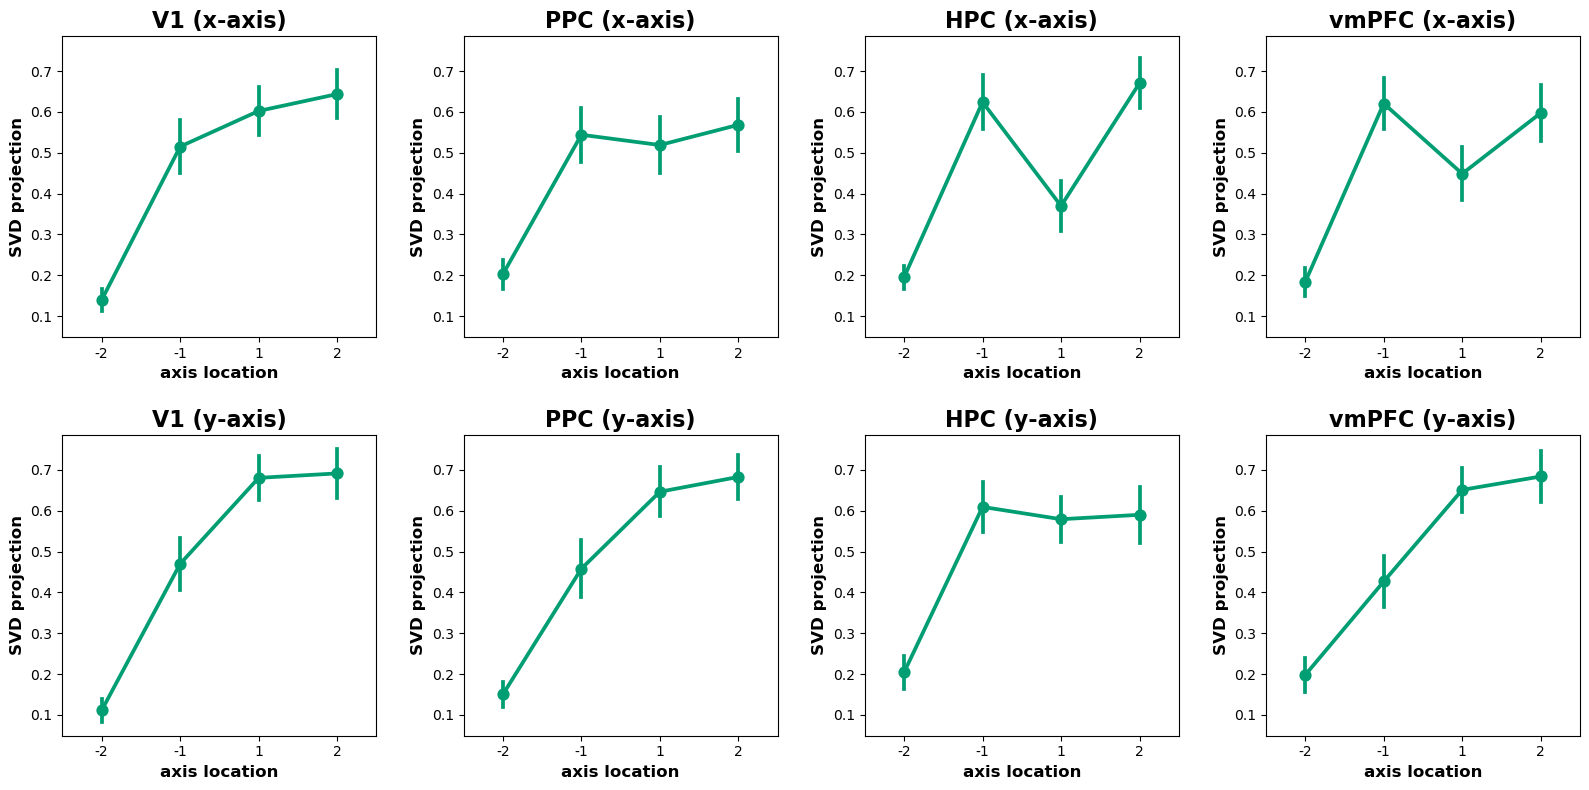

In [57]:
fig, axes = plt.subplots(2,4,figsize=(16,8),
                         sharey=True,sharex=True)

for jrow,dimonaxis in enumerate(["x axis","y axis"]):
    for kcol,roi in enumerate(["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"]):
        dot_color = colors.hex2color(participantgrouphex["Generalizer"])
        pdf = scaled_projection_df_sum.query("roi==@roi & dimonaxis==@dimonaxis").copy()
        pdf = pdf[pdf.subgroup=="Generalizer"].copy()
        ax = axes[jrow,kcol]
        
        sns.pointplot(data=pdf,
                        x="axisloc",y="SVD_projection_scaled",
                        #hue="subgroup",palette=participantgrouphex,
                        color=dot_color,label="Generalizer",
                        errorbar="se",
                        ax=ax)
        
        
        ax.legend_.remove()

        ax.set_title(f"{roi_shortnames[roi]} ({dimonaxis.replace(' ','-')})",fontdict=def_font_subplot_titles)   
        ax.set_xticks(
            ticks = [0,1,2,3],
            labels=["-2","-1","1","2"],
            fontdict=def_font_axis_tick_labels
            )
        ax.set_ylabel("SVD projection",fontdict=def_font_axis_legend_titles)
        ax.set_xlabel("axis location",fontdict=def_font_axis_legend_titles)
        ax.tick_params(labelleft=True, labelbottom=True)
        ax.xaxis.label.set_visible(True)
        ax.yaxis.label.set_visible(True)
        
fig.tight_layout(w_pad=2.5,h_pad=2)

# Geometry: Parallel vs Orthogonal Axis


Plots related to geometry, i.e., how the two rules are represented with respect to each other (Figure 3 of the main text). Make sure that the [`PTAregRSAtwofold.py`](multivariate/PTAregRSAtwofold.py), as well as the two MDS scripts [`computeAxisPS_navi.py`](multivariate/computeAxisPS_navi.py) and [`dimreduc_MDS_parallelaxisgroups.py`](multivariate/dimreduc_MDS_parallelaxisgroups.py) have been executed before running the plotting scripts in this section.

The code and plots for the illustrative models in figure 4 can be found in another jupyter notebook [here](illustrativeparallelmodel.ipynb)

## Load results

In [18]:
# load CVRSA results
PTAregRSA_CVres = load(os.path.join(ROIRSAdir,'axisPS','cvRSA',"ROI_PTARSA_2v2.pkl"))
PTAregRSA_CVres.keys()
ROIRSA_PTA_cvres = pd.concat(PTAregRSA_CVres["RSA"],axis=0).reset_index(drop=True)
ROIRSA_PTA_cvres.head(5)
ROIRSA_PTA_cvres_meandf = ROIRSA_PTA_cvres.groupby([ 'PSGROUProi', 'analysis', 'subid', 'modelrdm'])[['adjR2', 'R2', 'coefficient']].mean().reset_index()
ROIRSA_PTA_cvres_meandf["subgroup"] = ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in ROIRSA_PTA_cvres_meandf["subid"]]

# load precalculated PS and null distribution of PS
ROIPS_dict = load(os.path.join(ROIRSAdir,"axisPS","PS_NCtrainingstim.pkl"))
sub_cs_perms, sub_cs_obs = ROIPS_dict["permutation"], ROIPS_dict["observation"]
PS_classification = pd.read_csv(os.path.join(ROIRSAdir,"axisPS","PS_classification.csv"))
PS_classification["subgroup"] = pd.Categorical(
    ["Generalizers" if subid in generalizers else "nonGeneralizers" for subid in PS_classification["subid"]],
    categories=["Generalizers","nonGeneralizers"],ordered=True)
PS_classification["subcohort"] = pd.Categorical(
    ["First Cohort" if subid in cohort1ids else "Second Cohort" for subid in PS_classification["subid"]],
    categories=["First Cohort","Second Cohort"],ordered=True)

# load MDS results
## for all stimuli
rdm_mds_results = load(os.path.join(ROIRSAdir,"mds_results_rescaled.pkl"))
## for non-centre training stimuli
PSAXrdm_mds_results = load(os.path.join(ROIRSAdir,'axisPS','MDS',"ParallAx_nonmetricmds_results.pkl")) # nonmetric_



## Stats

In [19]:
parallelorthogonalfit_df = pd.DataFrame()
plt_pdf = ROIRSA_PTA_cvres_meandf[(ROIRSA_PTA_cvres_meandf.analysis=='train stim Compete PTAhigh Cartesian')].copy().reset_index(drop=True)
plt_pdf["modelrdm_shortname"] = pd.Categorical(
    plt_pdf["modelrdm"].map({"PTA_ax":"axis\nseparation","PTA_locNomial":"parallel","gtlocEuclidean":"orthogonal"}),
)   
plt_pdf.PSGROUProi = pd.Categorical(
    plt_pdf.PSGROUProi, 
    categories=["V1_bilateral","PPC_bilateral", "HPC_bilateral", "vmPFC_bilateral"],
    ordered=True
)
plt_pdf = plt_pdf[plt_pdf.subgroup=="Generalizer"].copy().reset_index(drop=True)   

for currroi,axdf in plt_pdf.groupby("PSGROUProi"):
    for j, (gname,gdf) in enumerate(axdf.groupby(["modelrdm_shortname","subgroup"])):
        pval = ttest1samp_equiv_permutation(gdf["coefficient"])
        print(f"{currroi} - {gname}: mean={'%.4f' % gdf['coefficient'].mean()}, pval={'%.4f' % pval}")
        parallelorthogonalfit_df = pd.concat([parallelorthogonalfit_df,
                                              pd.DataFrame({
                                                  "PSGROUProi":[currroi],
                                                  "modelrdm_shortname":[gname[0]],
                                                  "subgroup":[gname[1]],
                                                  "mu":[gdf["coefficient"].mean()],
                                                  "se":[compute_se(gdf["coefficient"])],
                                                  "n":[gdf["coefficient"].count()],
                                                  "pval":[pval]
                                              },index=[0])
                                              ],axis=0).reset_index(drop=True)

parallelorthogonalfit_df.to_csv(os.path.join(ROIRSAdir,"axisPS","cvRSA","coef_stat.csv"),index=False)

V1_bilateral - ('axis\nseparation', 'Generalizer'): mean=0.1504, pval=0.0002
V1_bilateral - ('orthogonal', 'Generalizer'): mean=0.0652, pval=0.0056
V1_bilateral - ('parallel', 'Generalizer'): mean=-0.0052, pval=0.7709
PPC_bilateral - ('axis\nseparation', 'Generalizer'): mean=0.0379, pval=0.0296
PPC_bilateral - ('orthogonal', 'Generalizer'): mean=0.0201, pval=0.3732
PPC_bilateral - ('parallel', 'Generalizer'): mean=-0.0068, pval=0.7425
HPC_bilateral - ('axis\nseparation', 'Generalizer'): mean=0.0318, pval=0.1156
HPC_bilateral - ('orthogonal', 'Generalizer'): mean=0.0318, pval=0.1354
HPC_bilateral - ('parallel', 'Generalizer'): mean=0.0470, pval=0.0040
vmPFC_bilateral - ('axis\nseparation', 'Generalizer'): mean=0.0075, pval=0.6423
vmPFC_bilateral - ('orthogonal', 'Generalizer'): mean=0.0529, pval=0.0366
vmPFC_bilateral - ('parallel', 'Generalizer'): mean=-0.0160, pval=0.5103


## Plots

### 1. Cross-validated RSA
Figure 3d-e

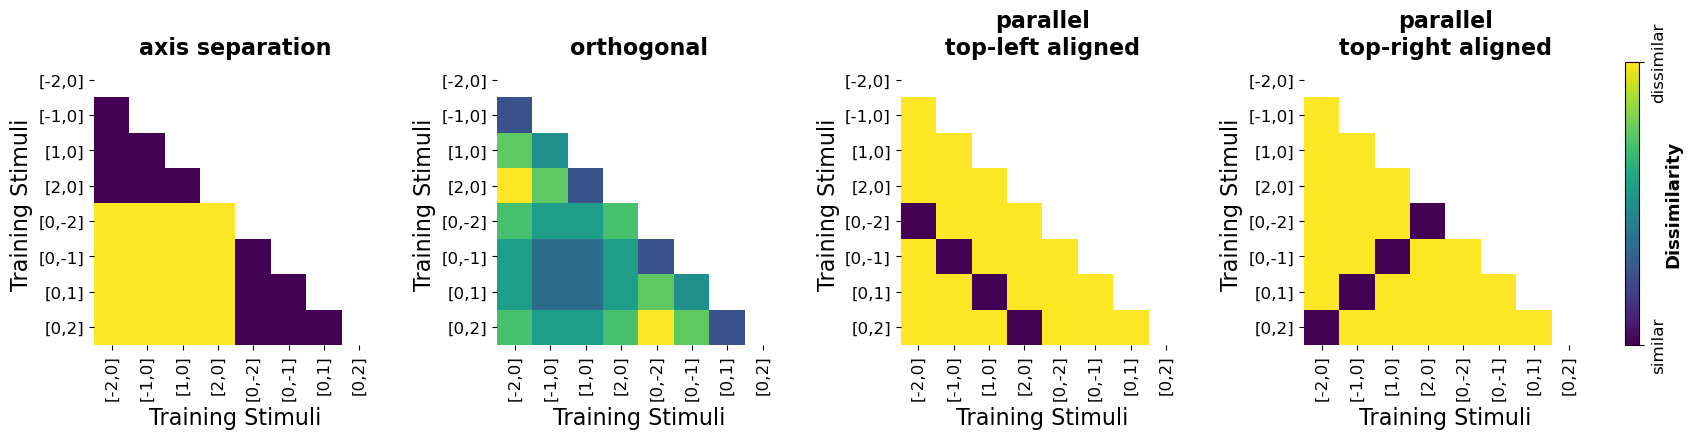

In [20]:
# plot model RDMs

nctrainingstim = roi_data["V1_bilateral"][0]["stimdf"].copy()
nct_filter = np.vstack(
    [np.logical_xor(nctrainingstim.stim_x.values == 0, nctrainingstim.stim_y.values == 0),
     nctrainingstim.stim_session==0
    ]
).all(axis=0)
nctrainingstim = nctrainingstim[nct_filter].copy().sort_values(by=["training_axset","training_axlocTL"])

alllabs = np.array([f"[{int(x)},{int(y)}]" for x,y in nctrainingstim[["stim_x","stim_y"]].to_numpy()*2])
allticks = np.arange(len(alllabs))

orthordm = compute_rdm(nctrainingstim[["stim_x","stim_y"]].to_numpy(),"euclidean")
paralltlrdm = compute_rdm_identity(nctrainingstim[["training_axlocTL"]].to_numpy())
paralltrrdm = compute_rdm_identity(nctrainingstim[["training_axlocTR"]].to_numpy())
axseprdm = compute_rdm_identity(nctrainingstim[["training_axset"]].to_numpy())

training_axes_modelrdms = {
    "axis separation":axseprdm,
    "orthogonal":orthordm,
    "parallel\ntop-left aligned":paralltlrdm,
    "parallel\ntop-right aligned":paralltrrdm
}
# create a single norm to be shared across all images
norm = colors.Normalize(vmin=np.min(list(training_axes_modelrdms.values())), vmax=np.max(list(training_axes_modelrdms.values())))

fig, axes = plt.subplots(1,4,figsize=(22*.9,4.5))
for j,(k,v) in enumerate(training_axes_modelrdms.items()):
    plot_v = np.full_like(v,fill_value=np.nan)
    plot_v[lower_tri(v)[1]] = lower_tri(v)[0]
    norm = colors.Normalize(vmin=np.min(v), vmax=np.max(v))
    if j == 0:
        im = axes[j].imshow(plot_v,cmap="viridis",norm=norm)
    else:
        axes[j].imshow(plot_v,cmap="viridis",norm=norm)
    axes[j].set_title(k,**def_font_subplot_titles)

for ax in axes.flatten():
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks(allticks)
    ax.set_yticks(allticks)
    ax.set_xticklabels(alllabs,rotation=90,fontsize=def_font_axis_legend_titles["fontsize"])
    ax.set_yticklabels(alllabs,rotation=0,fontsize=def_font_axis_legend_titles["fontsize"])
    ax.set_xlabel("Training Stimuli",fontsize=def_font_subplot_titles["fontsize"])
    ax.set_ylabel("Training Stimuli",fontsize=def_font_subplot_titles["fontsize"])
    ax.set_aspect(1)
    
#ax.set_yticks([])
#ax.set_ylabel("")
fig.tight_layout()
fig.tight_layout(w_pad=3)

#fig.suptitle("Model RDMs",y=1.04,**def_font_subplot_titles)
cb =fig.colorbar(im, ax=axes,orientation="vertical", fraction = 0.15, shrink=1, pad=0.02)
cb.set_label(label='Dissimilarity',weight=def_font_axis_legend_titles["fontweight"],fontsize=13,
             labelpad=-1)
cb.set_ticks(ticks=[norm.vmin, norm.vmax],
             labels=["similar","dissimilar"],fontsize=def_font_axis_legend_titles["fontsize"],rotation=90,va="center")
cb.ax.yaxis.set_tick_params(pad=5)

fig.savefig(os.path.join(ROIRSAdir,"finalfigs",f"fig4d.tif"),dpi=300,bbox_inches="tight")

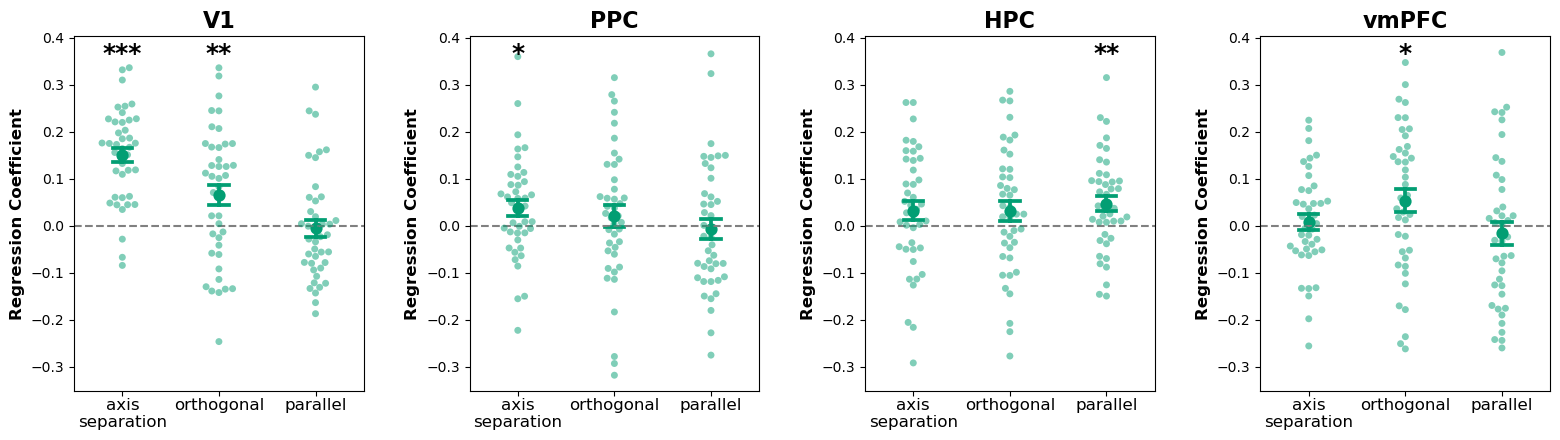

In [21]:
# plot beta estimates of model RDM
plt_pdf = ROIRSA_PTA_cvres_meandf[(ROIRSA_PTA_cvres_meandf.analysis=='train stim Compete PTAhigh Cartesian')].copy().reset_index(drop=True)
plt_pdf["modelrdm_shortname"] = pd.Categorical(
    plt_pdf["modelrdm"].map({"PTA_ax":"axis\nseparation","PTA_locNomial":"parallel","gtlocEuclidean":"orthogonal"}),
)   
plt_pdf.PSGROUProi = pd.Categorical(
    plt_pdf.PSGROUProi, 
    categories=["V1_bilateral","PPC_bilateral", "HPC_bilateral", "vmPFC_bilateral"],
    ordered=True
)
plt_pdf = plt_pdf[plt_pdf.subgroup=="Generalizer"].copy().reset_index(drop=True)   

gs = sns.catplot(
    plt_pdf,
    x="modelrdm_shortname",y="coefficient",
    col="PSGROUProi",
    hue="subgroup",palette=participantgrouphex,
    kind = "point", errorbar="se", capsize=.2,linestyle="none",#fill=False,

    height=4.5,aspect=0.8
).set_titles("{col_name}").refline(y=0)
gs.map_dataframe(sns.swarmplot,x="modelrdm_shortname",y="coefficient",
                 hue="subgroup",palette=participantgrouphex,dodge=True,
                 linewidth=0,alpha=0.5,size=5)
gs.set_xlabels("Model RDM",fontsize=14,fontweight="bold")
gs.set_ylabels("Regression Coefficient",fontsize=14,fontweight="bold")
#sns.move_legend(gs, "upper right", bbox_to_anchor=(0.72, 0.35), fontsize=13,title="")
gs.legend.remove()

hs,ls = gs.axes.flatten()[0].get_legend_handles_labels()
for ax in gs.axes.flatten():
    axdf = plt_pdf[plt_pdf["PSGROUProi"]==ax.get_title()].copy()
    currroi = axdf["PSGROUProi"].unique()[0]
    plt.setp(ax.get_xticklabels(), rotation=0,fontsize=def_font_axis_legend_titles["fontsize"],ha="center",va="top")
    ax.tick_params(axis='x',pad=1)
    ax.set_xlabel("")
    ax.set_ylabel("Regression Coefficient",**def_font_axis_legend_titles)
    for j, (gname,gdf) in enumerate(axdf.groupby(["modelrdm_shortname","subgroup"])):
        pval = ttest1samp_equiv_permutation(gdf["coefficient"])
        ax.text(j,y=0.35,s=f"{gen_pval_annot(pval,show_pval=False)}",
                fontsize=18,fontweight="bold",color="black",
                ha="center")
        
        
    ax.set_title(roi_shortnames[axdf["PSGROUProi"].unique()[0]],**def_font_subplot_titles)
    ax.tick_params(labelleft=True, labelbottom=True)
    ax.xaxis.label.set_visible(True)
    ax.yaxis.label.set_visible(True)
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
    ax.legend().remove()

#gs.figure.set_size_inches(18.8,4)
gs.figure.tight_layout(w_pad=3) 
gs.figure.savefig(os.path.join(ROIRSAdir,"finalfigs","fig3abcd.tif"),bbox_inches='tight',dpi=300)   


### 2. distribution of HPC PS
Figure 3j


HPC_bilateral Generalizers: 
NormaltestResult(statistic=1.6968765336440044, pvalue=0.42808296153492953)
Generalizer PS comes from: N(0.016,0.039)
Null PS comes from: N(-0.000,0.008)
Levene’s test p-value: 0.000


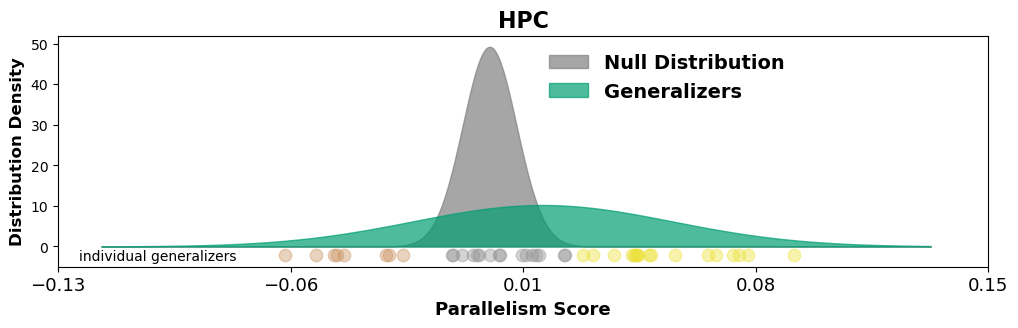

In [22]:
def simulate_dist_data(distribution="norm",mu=0, sigma=1, n_samples=1000,x=None,c=0):
    if x is None:
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, n_samples)
    elif isinstance(x, (list, tuple, np.ndarray)):
        if np.size(x)==2:
            x = np.linspace(x[0], x[1], n_samples)
        else:
            x = np.array(x)
    if distribution == "norm":
        y = scipy.stats.norm.pdf(x, mu, sigma)
    elif distribution == "foldnorm":
        y = scipy.stats.foldnorm .pdf(x, loc=mu, scale=sigma,c=c)
    return x, y


roi = "HPC_bilateral"

fig_HPCcs,axes_HPCcs = plt.subplots(1,1,figsize=(12,3))
    
# get null and observed parallelism scores
cs_null = np.array(sub_cs_perms[roi]).mean(axis=0)

cs_G = [cs for cs,subid in zip(sub_cs_obs[roi],subid_list) if subid in generalizers]
cs_NG = [cs for cs,subid in zip(sub_cs_obs[roi],subid_list) if subid in nongeneralizers]

G_null = np.array([cs for cs,subid in zip(sub_cs_perms[roi],subid_list) if subid in generalizers]).mean(axis=0)
nG_null = np.array([cs for cs,subid in zip(sub_cs_perms[roi],subid_list) if subid in nongeneralizers]).mean(axis=0)

# calculate absolute values of parallelism scores    
abscs_G = np.abs(cs_G)
abscs_nG = np.abs(cs_NG)

csabs_null = np.abs(cs_null)

# fit normal distribution
G_mu, G_std = scipy.stats.norm.fit(cs_G)
null_mu, null_std = scipy.stats.norm.fit(cs_null)

print(f"\n{roi} Generalizers: ")
print(f"{scipy.stats.normaltest(cs_G)}")
print(f"Generalizer PS comes from: N({G_mu:.3f},{G_std:.3f})")
print(f"Null PS comes from: N({null_mu:.3f},{null_std:.3f})")

var_stat, var_p = scipy.stats.levene(cs_G, cs_null)
print(f"Levene’s test p-value: {var_p:.3f}")

# find max range
simx_range = (0,0)
max_std = np.max([G_std, null_std])
curr_range = (np.min([G_mu-3*max_std, null_mu-3*max_std]), 
                np.max([G_mu+3*max_std, null_mu+3*max_std]))
simx_range = (min(curr_range[0], simx_range[0]), max(curr_range[1], simx_range[1]))

# plot the fitted normal distributions for PS
axes_HPCcs.fill_between(*simulate_dist_data(distribution="norm",mu=null_mu, sigma=null_std, n_samples=1000,x=simx_range),color="grey",
                        alpha=.7,
                        label="Null Distribution")
axes_HPCcs.fill_between(*simulate_dist_data(distribution="norm",mu=G_mu, sigma=G_std, n_samples=1000,x=simx_range),color=participantgrouphex["Generalizer"],
                        alpha=.7,
                        label="Generalizers")

for x,subid,subrc in zip(sub_cs_obs[roi],subid_list,PS_classification[roi]):
    if subid in generalizers:
        alpha_v = 0.4
        axes_HPCcs.scatter(x,y=-2,color=psgroupnum_huedict[subrc],alpha=alpha_v,s=80)


axes_HPCcs.set_title(roi_shortnames[roi],**def_font_subplot_titles)
axes_HPCcs.set_xlabel("Parallelism Score",fontsize=13,fontweight="bold")
axes_HPCcs.set_ylabel("Distribution Density",**def_font_axis_legend_titles)

axes_HPCcs.text(-0.1,-2.5,"individual generalizers", ha="center",va="center",fontsize=10)

axes_HPCcs.legend(loc="upper right",bbox_to_anchor=(0.8,1.0),ncol=1,
                  
          prop = dict(weight="bold",size=14),frameon=False)
# set the x and y limits and ticks for the PS plot axes
axcs_xlim, axabscs_xlim = (0,0), (0,0)
axcs_xlim = (min(axes_HPCcs.get_xlim()[0],axcs_xlim[0]), max(axes_HPCcs.get_xlim()[1],axcs_xlim[1]))
axcs_xticks = np.round(np.linspace(axcs_xlim[0], axcs_xlim[1], 5),2)
axes_HPCcs.set_ylim(-5,52)
axes_HPCcs.set_xticks(axcs_xticks)
plt.setp(axes_HPCcs.get_xticklabels(), fontsize=13)
plt.savefig(os.path.join(ROIRSAdir,"finalfigs","fig3j.tif"),bbox_inches='tight',dpi=300)


### 3. MDS plots

#### MDS of HPC non-centre training stimuli representations with different PS groups
Figure 3k

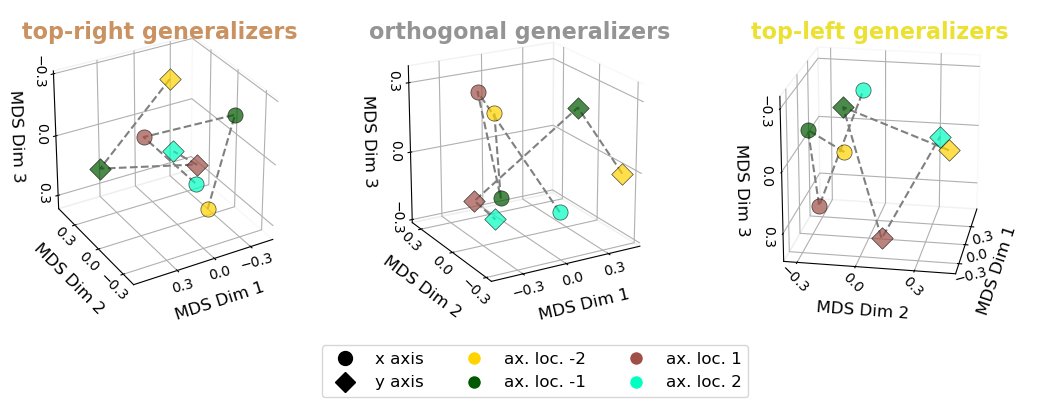

In [23]:
ssname = "training_nocenter"
roi = "HPC_bilateral" #"testgtlocParietalSup_bilateral"

ncompo = 3
fig = plt.figure(figsize=(15,6))
#view_inits = {"top-left":[0,-100,0],"top-right":[20,-100,0],"orthogonal":[0,125,0]}
view_inits = {"top-left":[-20,170,180],"top-right":[-30,-60,180],"orthogonal":[20,-120,0]}
#ax.view_init(elev=-20, azim=170,roll=180)
for jgroup,psgroupname in enumerate(['top-right','orthogonal','top-left']):

    plot_title=f"{psgroupname} generalizers"

    roirdm, roimdsdf = deepcopy(PSAXrdm_mds_results["aveRDM"][ssname][roi][psgroupname]["G"]),deepcopy(PSAXrdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][psgroupname]["G"])
    roimdsdf["stim_name"] = ["%s%d"%(x,y) for x,y in roimdsdf[["training_axsetstr","training_axlocTL"]].to_numpy()]

    roimdsdf# = roimdsdf.iloc[[0,1]].copy()
    ax = fig.add_subplot(1,3,jgroup+1, projection='3d')


    # Plot each group with different color and marker
    for (ta, tl), group in roimdsdf.groupby(['training_axsetstr', 'training_axlocTL']):
        ax.scatter(group['MDS1'], group['MDS2'], group['MDS3'],
                color=stimycolorhex[tl], marker=axis_group_markers[ta],
                s=120,edgecolor='black',linewidth=0.5,
                label=f'{ta},{tl}',alpha=0.7)
        #if ta=="x":
        #    ax.text(group['MDS1'].values[0]+0.06, group['MDS2'].values[0]+0.05, group['MDS3'].values[0],s=f"{ta}={int(tl)}",ha="left")
        #else:
        #    ax.text(group['MDS1'].values[0]-0.05, group['MDS2'].values[0]+0.05, group['MDS3'].values[0],s=f"{ta}={int(tl)}",ha="right")
    

    for ta,group in roimdsdf.groupby('training_axsetstr'):
        ax.plot(group['MDS1'], group['MDS2'], group['MDS3'],
                color="grey",linestyle="--")    

    # Create custom legends
    color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='ax. loc. %d'%(i))
                    for i in np.sort(roimdsdf["training_axlocTL"].unique())]
    marker_legend = [plt.Line2D([0], [0], marker=axis_group_markers[i], color='k', markerfacecolor='k',linewidth=0, markersize=10, label='%s axis'%(i)) 
                    for i in np.sort(roimdsdf["training_axsetstr"].unique())]

    # Set plot title and labels
    ax.set_title(plot_title,y=0.95,fontdict={"weight":"bold","size":def_font_subplot_titles["fontsize"],"color":psgroup_huedict[psgroupname]}) # - {cname} Generalizers
    ax.set_xlabel('MDS Dim 1',fontdict={"size":def_font_axis_legend_titles["fontsize"]},labelpad=0.05)
    ax.set_ylabel('MDS Dim 2',fontdict={"size":def_font_axis_legend_titles["fontsize"]},labelpad=0.1)
    ax.set_zlabel('MDS Dim 3',fontdict={"size":def_font_axis_legend_titles["fontsize"]},labelpad=0.1)

    ax.view_init(*view_inits[psgroupname])
    ax.set_box_aspect([1, 1, 1]) 

    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False

    def compute_ticks(data,decplace=1):
        min_val,max_val = np.round(np.min(data),decimals=decplace),np.round(np.max(data),decimals=decplace)
        ran = max_val - min_val
        D = np.ceil(ran/10**(-decplace)/2).astype(int)
        ticks = np.linspace(min_val,max_val,D,endpoint=True)
        return ticks
    ticks = [-0.3,0,0.3]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_zticks(ticks)
    plt.setp(ax.get_xticklabels(), rotation=15,ha="center",va="center",**def_font_axis_tick_labels)
    plt.setp(ax.get_zticklabels(), rotation=-90,ha="center",va="center",**def_font_axis_tick_labels)
    # Adjust the axis limits to avoid cropping
    
    #if jgroup<2:
    ax.legend().remove()
    plt.setp(ax.get_yticklabels(), rotation=-45,ha="center",va="center")
    if jgroup==0:
        ax.set_box_aspect([1,1,1], zoom=0.9) 
    elif jgroup==1:
        ax.set_box_aspect([1, 1, 1], zoom=0.95) 
    else:
        ax.set_box_aspect([1, 1,1 ], zoom=0.95)
       # ax.set_yticks([])
    ax.tick_params(pad=0)
fig.legend(handles=marker_legend + color_legend, loc='upper center', 
           bbox_to_anchor=(0.35, 0.23),fontsize=def_font_axis_legend_titles["fontsize"],
           ncol=3)
fig.subplots_adjust(hspace=0,left=0,right=0.68,bottom=0.05,top=1)
fig.savefig(os.path.join(ROIRSAdir,"finalfigs","fig3k.tif"),bbox_inches='tight',dpi=300)

plt.show()

#### MDS of V1 representation of all stimuli
Figure 3i

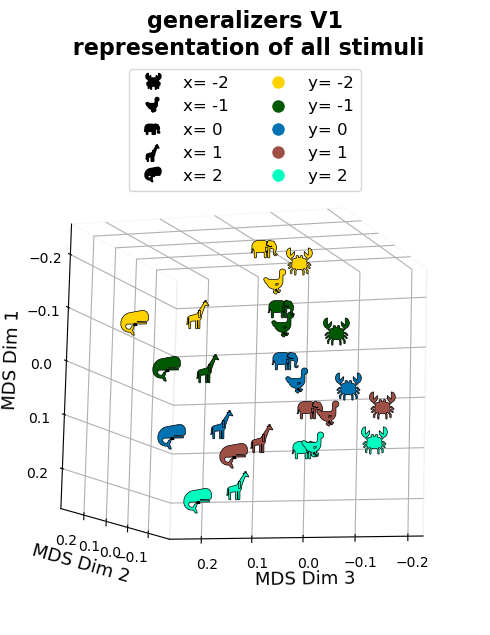

In [24]:
ssname = "allstim"
roi = "V1_bilateral"
cname = "Combined Cohort"
ncompo = 3

plot_title=f"generalizers V1\n representation of all stimuli"

roirdm, roimdsdf = rdm_mds_results["aveRDM"][ssname][roi][cname]["G"],rdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][cname]["G"]
roimdsdf["stim_name"] = ["%d,%d"%(x,y) for x,y in roimdsdf[["stim_x","stim_y"]].to_numpy()]

roimdsdf# = roimdsdf.iloc[[0,1]].copy()

fig = plt.figure(figsize=(5,7))
ax = fig.add_subplot(111, projection='3d')

# Plot each group with different color and marker
for (stim_x, stim_y), group in roimdsdf.groupby(['stim_x', 'stim_y']):
    #for p in stimxanimalmarkers[stim_x]:
    ax.scatter(group['MDS1'], group['MDS2'], group['MDS3'],
            color=stimycolorhex[stim_y], marker=stimxanimalmarkers[stim_x],
            s=500,edgecolor='black',linewidth=0.5,
            label=f'{stim_x},{stim_y}')

# Create custom legends
color_legend = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=stimycolorhex[i], markersize=10, label='y= %d'%(i))
                for i in np.sort(roimdsdf["stim_y"].unique())]
marker_legend = [plt.Line2D([0], [0], marker=stimxanimalmarkers[i], color='k', markerfacecolor='k',linewidth=0, markersize=13, label='x= %d'%(i)) 
                 for i in np.sort(roimdsdf["stim_x"].unique())]

# Set plot title and labels
ax.set_title(plot_title,y=1.3,fontdict=def_font_subplot_titles) # - {cname} Generalizers
ax.set_xlabel('MDS Dim 1',fontdict={"size":13})
ax.set_ylabel('MDS Dim 2',fontdict={"size":13})
ax.set_zlabel('MDS Dim 3',fontdict={"size":13})

ax.view_init(elev=-20, azim=80,roll=92)
ax.set_box_aspect([1, 1, 1]) 
ax.legend(handles=marker_legend + color_legend, 
          loc='upper center', 
          bbox_to_anchor=(0.5, 1.2),
          ncol=2,
          fontsize=def_font_axis_legend_titles["fontsize"])

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Adjust the axis limits to avoid cropping
fig.tight_layout()
plt.show()
fig.savefig(os.path.join(ROIRSAdir,"finalfigs","fig3i.tif"),bbox_inches='tight',dpi=300)

# Vector addition composition
Plots related to dimensionality (Figure 5 of the main text). Make sure that the [`compute_train2testRetrievalPatternCV.py`](multivariate/compute_train2testRetrievalPatternCV.py) has been executed before running the plotting scripts in this section.

## Load results

In [25]:
retrivepat_res = load(os.path.join(ROIRSAdir,"retrievalpatternCV","resoverview","retrievalpatternCV_results.pkl"))


compositionretrieval_resdf = retrivepat_res["results"].copy()
compositionretrieval_resdf[["analysis","metricname"]] = compositionretrieval_resdf.metric.str.split("-",expand=True)
compositionretrieval_resdf["region"] = [x.split("_")[0] for x in compositionretrieval_resdf.roi]

train2testencoding_resdf = compositionretrieval_resdf.query("analysis=='train2test'").copy()
train2testencoding_resdf = train2testencoding_resdf.join(svdestdim_df_sum_overaxis.set_index(["roi","subid"]),on=["roi","subid"],rsuffix="_svd")
train2testencoding_resdf = train2testencoding_resdf[train2testencoding_resdf.roi.isin(rois)]
print(train2testencoding_resdf.metricname.unique())

compositionretrieval_resdf["subgroup"] = pd.Categorical(
    ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in compositionretrieval_resdf["subid"]],
    categories=["Generalizer","nonGeneralizer"],ordered=True    
)

compo_retrieve_roisubset_df = compositionretrieval_resdf[(compositionretrieval_resdf.subid.isin(generalizers))].copy() 


['fit_corr_O2E' 'eval_corr_O2E' 'fit_corr_E2O' 'eval_corr_E2O' 'fit_r2'
 'eval_r2' 'fit_corr' 'eval_corr' 'reg_distmod' 'reg_percept'
 'compoweight_x' 'compoweight_y' 'compoweight' 'noncompoweight_x'
 'noncompoweight_y' 'noncompoweight' 'meanweightdiff' 'meanweightdiff_x'
 'meanweightdiff_y']


## Stats

In [26]:
compo_retrieve_roisubset_df.metricname.unique()

array(['fit_corr_O2E', 'eval_corr_O2E', 'fit_corr_E2O', 'eval_corr_E2O',
       'fit_r2', 'eval_r2', 'fit_corr', 'eval_corr', 'reg_distmod',
       'reg_percept', 'compoweight_x', 'compoweight_y', 'compoweight',
       'noncompoweight_x', 'noncompoweight_y', 'noncompoweight',
       'meanweightdiff', 'meanweightdiff_x', 'meanweightdiff_y'],
      dtype=object)

### 1. Sanity Checks  
(1) coefficient of determination > 0   
(2) retrieval weights for relevant > 0   
(3) difference in mean retrieval weights for (relelvant - irrelevant) > 0

In [27]:
pdf = compo_retrieve_roisubset_df[(compo_retrieve_roisubset_df.metricname.isin(['eval_r2','compoweight_x','compoweight_y','meanweightdiff_x', 'meanweightdiff_y']))].copy()
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],ordered=True)
pdf=pdf[pdf.subgroup.isin(["Generalizer"])].copy()

vectoraddition_sc_df = pd.DataFrame()
for (metricname,currroi,sg), tardf in pdf.groupby(["metricname","roi","subgroup"]):
    pval = ttest1samp_equiv_permutation(tardf.value.values,alternative="greater") # because we have very specific hypo about the direction of effect
    print(f"{roi_shortnames[currroi]}  {metricname}: mean = {'%.3f' % tardf.value.values.mean()}, p-value = {'%.4f' % pval}")
    
    vectoraddition_sc_df = pd.concat([vectoraddition_sc_df,
                                              pd.DataFrame({
                                                  "PSGROUProi":[currroi],
                                                  "metricname":[metricname],
                                                  "subgroup":[sg],
                                                  "mu":[tardf.value.values.mean()],
                                                  "se":[compute_se(tardf.value.values)],
                                                  "n":[tardf.value.count()],
                                                  "pval":[pval]
                                              },index=[0])
                                              ],axis=0).reset_index(drop=True)

vectoraddition_sc_df.to_csv(os.path.join(ROIRSAdir,"retrievalpatternCV","resoverview","compo_retrieve_sanitycheck_stat.csv"),index=False)



V1  compoweight_x: mean = 0.112, p-value = 0.0001
PPC  compoweight_x: mean = 0.092, p-value = 0.0001
HPC  compoweight_x: mean = 0.063, p-value = 0.0001
vmPFC  compoweight_x: mean = 0.064, p-value = 0.0001
V1  compoweight_y: mean = 0.119, p-value = 0.0001
PPC  compoweight_y: mean = 0.089, p-value = 0.0001
HPC  compoweight_y: mean = 0.062, p-value = 0.0001
vmPFC  compoweight_y: mean = 0.063, p-value = 0.0001
V1  eval_r2: mean = 0.150, p-value = 0.0001
PPC  eval_r2: mean = 0.117, p-value = 0.0001
HPC  eval_r2: mean = -0.008, p-value = 0.9827
vmPFC  eval_r2: mean = 0.012, p-value = 0.0003
V1  meanweightdiff_x: mean = 0.031, p-value = 0.0001
PPC  meanweightdiff_x: mean = 0.006, p-value = 0.0387
HPC  meanweightdiff_x: mean = 0.003, p-value = 0.1679
vmPFC  meanweightdiff_x: mean = 0.006, p-value = 0.0171
V1  meanweightdiff_y: mean = 0.038, p-value = 0.0001
PPC  meanweightdiff_y: mean = 0.007, p-value = 0.0031
HPC  meanweightdiff_y: mean = 0.005, p-value = 0.0585
vmPFC  meanweightdiff_y: mean 

### 2. High-D vs Low-D composition

In [28]:
pdf = compo_retrieve_roisubset_df[(compo_retrieve_roisubset_df.metricname.isin(['reg_percept','reg_distmod']))].copy()
printhldname = {'reg_percept':"highD",'reg_distmod':"lowD"}
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],ordered=True)
pdf=pdf[pdf.subgroup.isin(["Generalizer"])].copy()

vectoraddition_dim_df = pd.DataFrame()
for (currroi,metricname,sg), tardf in pdf.groupby(["roi","metricname","subgroup"]):
    pval = ttest1samp_equiv_permutation(tardf.value.values,alternative="two-sided")
    print(f"{roi_shortnames[currroi]}  {printhldname[metricname]}: mean = {'%.3f' % tardf.value.values.mean()}, p-value = {'%.4f' % pval}")
    
    vectoraddition_dim_df = pd.concat([vectoraddition_dim_df,
                                              pd.DataFrame({
                                                  "PSGROUProi":[currroi],
                                                  "metricname":[metricname],
                                                  "subgroup":[sg],
                                                  "mu":[tardf.value.values.mean()],
                                                  "se":[compute_se(tardf.value.values)],
                                                  "n":[tardf.value.count()],
                                                  "pval":[pval]
                                              },index=[0])
                                              ],axis=0).reset_index(drop=True)

vectoraddition_dim_df.to_csv(os.path.join(ROIRSAdir,"retrievalpatternCV","resoverview","compo_retrieve_dimensionality_stat.csv"),index=False)



V1  lowD: mean = 0.067, p-value = 0.0012
V1  highD: mean = 0.222, p-value = 0.0002
PPC  lowD: mean = 0.059, p-value = 0.0006
PPC  highD: mean = 0.015, p-value = 0.3144
HPC  lowD: mean = -0.008, p-value = 0.6557
HPC  highD: mean = 0.032, p-value = 0.0436
vmPFC  lowD: mean = 0.019, p-value = 0.2230
vmPFC  highD: mean = 0.039, p-value = 0.0082


## Plots

### 1. plot model and empirical retrieval pattern matrices
Figure 5b

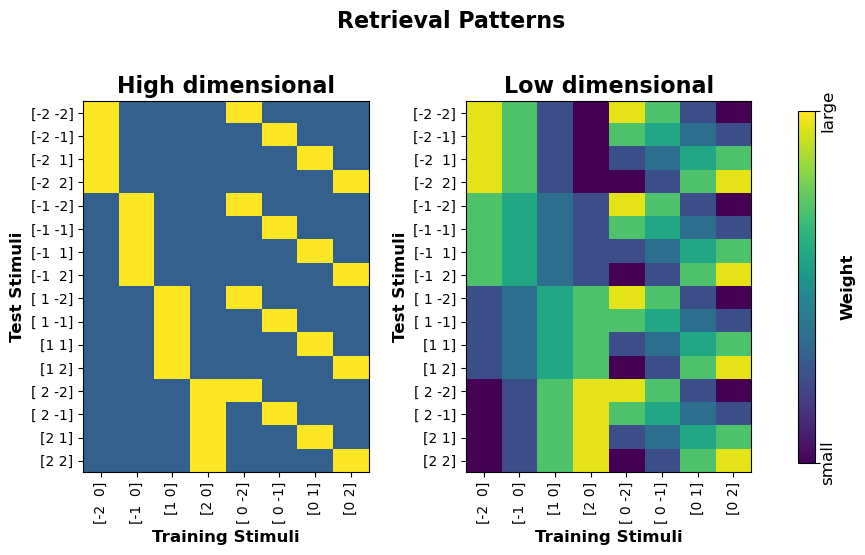

In [29]:
from scipy.spatial.distance import cdist
from sklearn.linear_model import LinearRegression
config_locrep  = np.array(list(itertools.product([-2,-1,1,2],[-2,-1,1,2])))
compo_locrep   = np.vstack([list(itertools.product([-2,-1,1,2],[0])),
                           list(itertools.product([0],[-2,-1,1,2]))])
compo_locrep
# high-d model is computed from perceptual mataching
percept_reg_coefs = cdist(config_locrep, compo_locrep, lambda u,v: sum(u==v))
# low-d model is computed from regression on low d vectors
dist_mod_reg_coefs = LinearRegression(fit_intercept=False,positive=False).fit(compo_locrep.T, config_locrep.T).coef_


# or we can get it from the results
example_models = deepcopy(retrivepat_res["coefs"]["PPC_bilateral"]["models"]['train2test'])# in the order of [percept_reg_coefs,dist_mod_reg_coefs]
assert np.array_equal(percept_reg_coefs,example_models[0])
assert np.array_equal(dist_mod_reg_coefs,example_models[1])

percept_reg_coefs = example_models[0]
dist_mod_reg_coefs = example_models[1]

stim_df = roi_data["V1_bilateral"][0]["stimdf"].copy()
test_df = stim_df[stim_df.stim_group==0].copy().reset_index(drop=True)
training_df = stim_df[stim_df.stim_group==1].copy().reset_index(drop=True)
training_df.sort_values(by=["training_axset","training_axlocTL"],inplace=True)
allylabs = (test_df[test_df.stim_session==0].copy()[["stim_x","stim_y"]].to_numpy()*2).astype(int)
allxlabs = (training_df[training_df.stim_session==0].copy()[["stim_x","stim_y"]].to_numpy()*2).astype(int)
xticksat = np.arange(0,8,1)
yticksat = np.arange(0,16,1)

def rescale_mat(mat,newmin=0,newmax=1):
    mat = np.array(mat)
    omin,omax = mat.min(),mat.max()
    return (mat-omin)/(omax-omin)*(newmax-newmin)+newmin

roi = "V1_bilateral"
ana="train2test"
fig,axes = plt.subplots(1,2,figsize=(10,5))
pmodel = scale_feature(percept_reg_coefs,2)
dmodel = scale_feature(dist_mod_reg_coefs,2)

# create a single norm to be shared across all images
norm = colors.Normalize(vmin=np.min([pmodel,dmodel]), vmax=np.max([pmodel,dmodel]))

im1 = axes[0].imshow(pmodel,cmap="viridis",norm=norm)
axes[0].set_title(f"High dimensional",**def_font_subplot_titles)
im2 = axes[1].imshow(dmodel,cmap="viridis",norm=norm)
axes[1].set_title(f"Low dimensional",**def_font_subplot_titles)
 

for ax,im in zip(axes.flatten(),[im1,im2]):
    ax.set_xticks(xticksat)
    ax.set_yticks(yticksat)
    ax.set_xticklabels(allxlabs[xticksat],rotation=90,**def_font_axis_tick_labels)
    ax.set_yticklabels(allylabs[yticksat],rotation=0,**def_font_axis_tick_labels)
    ax.set_xlabel("Training Stimuli",**def_font_axis_legend_titles)
    ax.set_ylabel("Test Stimuli",**def_font_axis_legend_titles)
    ax.set_aspect(0.65)


fig.tight_layout(h_pad=5)

fig.suptitle("Retrieval Patterns",y=1.1,**def_font_subplot_titles)
cb =fig.colorbar(im1, ax=axes,
                 orientation="vertical", 
                 location="right",
                 fraction = 0.15, shrink=0.95,
                 pad=0.05)
cb.set_label(label='Weight',weight=def_font_axis_legend_titles["fontweight"],fontsize=def_font_axis_legend_titles["fontsize"])
cb.set_ticks(ticks=[np.min([pmodel,dmodel]), np.max([pmodel,dmodel])],
             labels=["small","large"],fontsize=def_font_axis_legend_titles["fontsize"],rotation=90,va="center")
cb.ax.yaxis.set_tick_params(pad=0)

Text(0.5, 1.1, 'Retrieval Patterns in ROI')

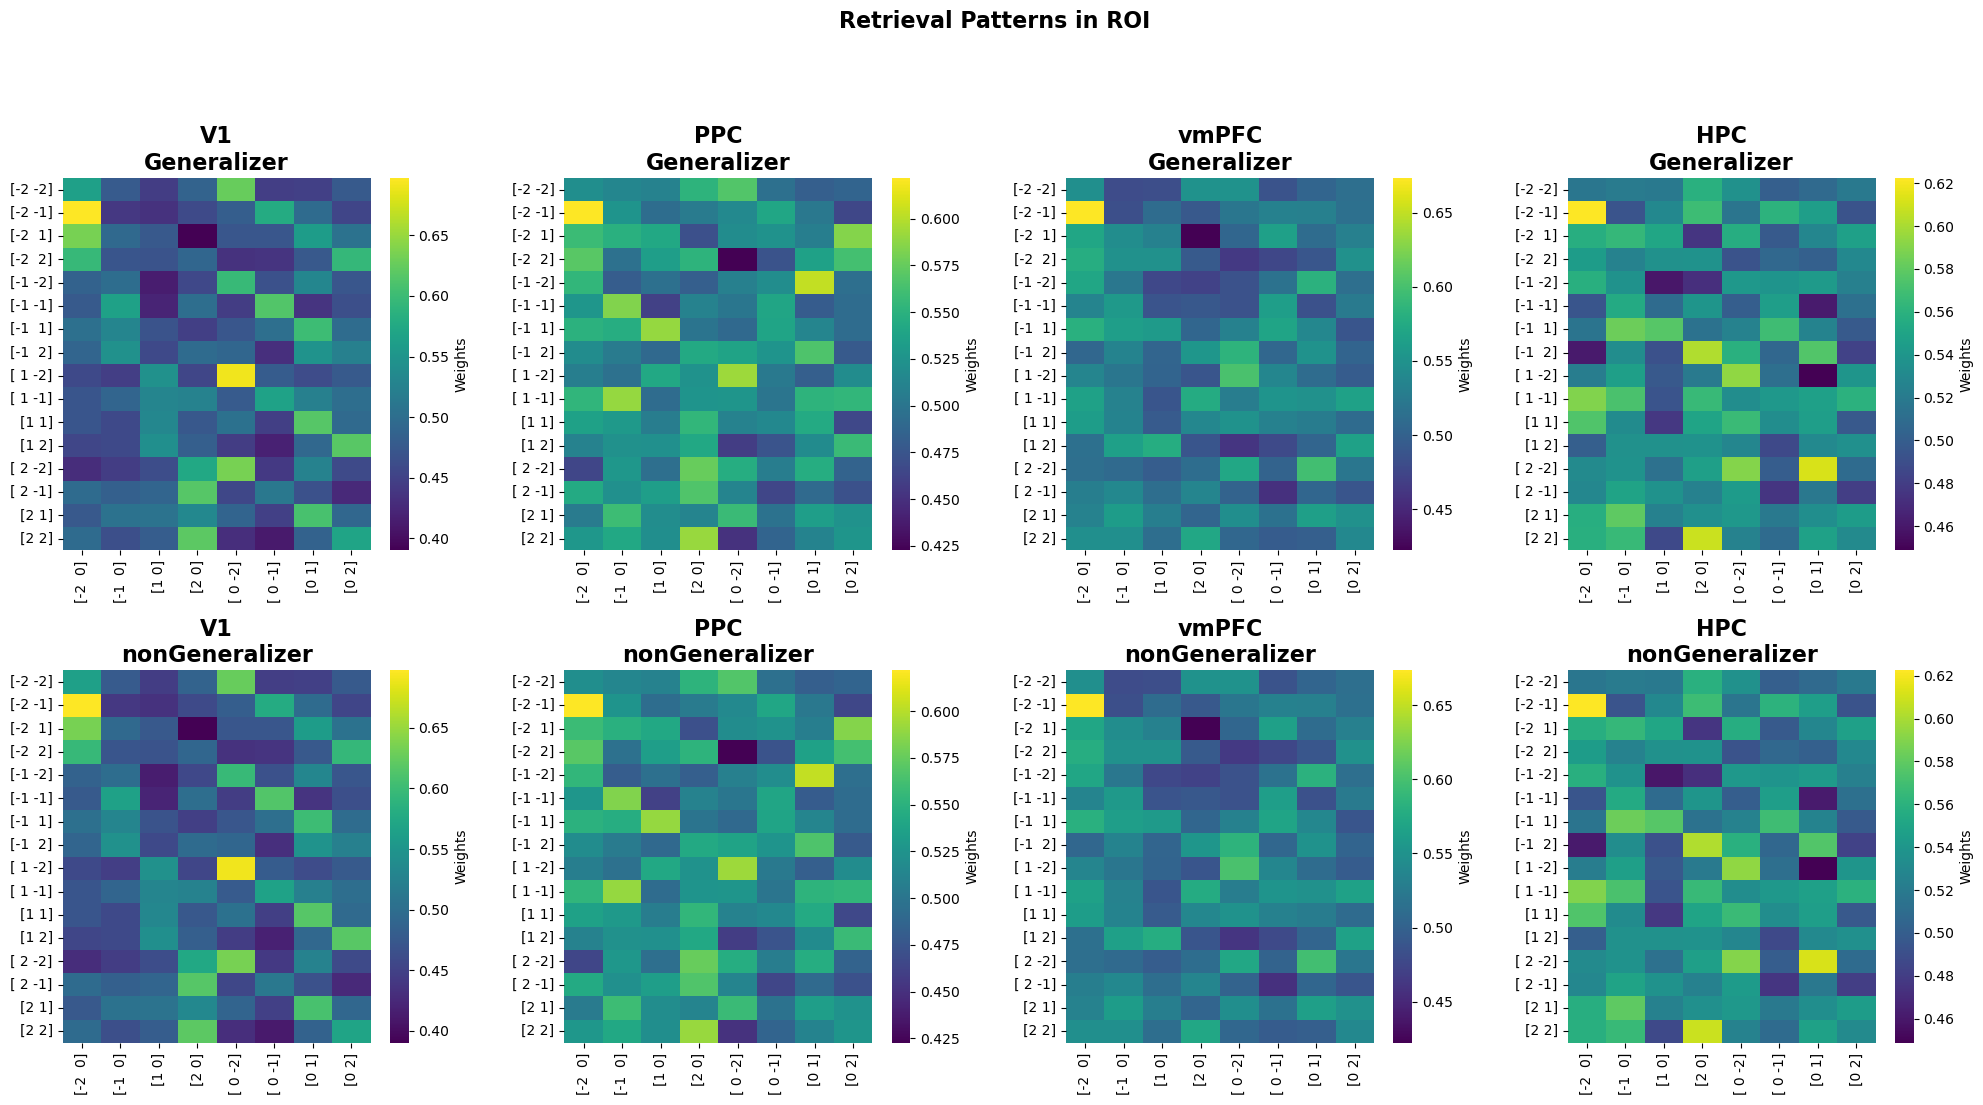

In [30]:
#bonus: visualize the mean over all empirical matrices for each ROI
def rescale_mat(mat,newmin=0,newmax=1):
    mat = np.array(mat)
    omin,omax = mat.min(),mat.max()
    return (mat-omin)/(omax-omin)*(newmax-newmin)+newmin
    
mean_regcoef_G = {}
mean_regcoef_nG = {}

for roi in rois:
    mean_regcoef_G[roi] = np.mean([rescale_mat(x) for x,subid in zip(retrivepat_res["coefs"][roi]["train2test"], subid_list) if subid in generalizers],axis=0)
    mean_regcoef_nG[roi] = np.mean([rescale_mat(x) for x,subid in zip(retrivepat_res["coefs"][roi]["train2test"], subid_list) if subid in nongeneralizers],axis=0)


fig,axes = plt.subplots(2,4,figsize=(20,10))

for kcol,roi in enumerate(["V1_bilateral","PPC_bilateral","vmPFC_bilateral","HPC_bilateral"]):
    stim_df = roi_data[roi][0]["stimdf"].copy()
    test_df = stim_df[stim_df.stim_group==0].copy().reset_index(drop=True)
    training_df = stim_df[stim_df.stim_group==1].copy().reset_index(drop=True)
    training_df.sort_values(by=["training_axset","training_axlocTL"],inplace=True)
    allylabs = (test_df[test_df.stim_session==0].copy()[["stim_x","stim_y"]].to_numpy()*2).astype(int)
    allxlabs = (training_df[training_df.stim_session==0].copy()[["stim_x","stim_y"]].to_numpy()*2).astype(int)
    xticksat = np.arange(0,8,1)
    yticksat = np.arange(0,16,1)


    sns.heatmap(mean_regcoef_G[roi],
                ax=axes[0,kcol],
                xticklabels=allxlabs[xticksat],
                yticklabels=allylabs[yticksat],
                cbar=True,cmap="viridis",cbar_kws={"label":"Weights"})
    sns.heatmap(mean_regcoef_G[roi],
                ax=axes[1,kcol],
                xticklabels=allxlabs[xticksat],
                yticklabels=allylabs[yticksat],
                cbar=True,cmap="viridis",cbar_kws={"label":"Weights"})
    axes[0,kcol].set_title(f"{roi_shortnames[roi]}\nGeneralizer",**def_font_subplot_titles)
    axes[1,kcol].set_title(f"{roi_shortnames[roi]}\nnonGeneralizer",**def_font_subplot_titles)
    

fig.tight_layout(w_pad=2)

fig.suptitle("Retrieval Patterns in ROI",y=1.1,**def_font_subplot_titles)


### 2. Sanity checks  
(1) coefficient of determination  - Figure 5c  
(2) retrieval weights for relevant  - Figure S4 top panels  
(3) difference in mean retrieval weights for (relelvant - irrelevant) - Figure S4 bottom panels  

PPC  ('V1_bilateral', 'Generalizer'): mean = 0.150, p-value = 0.0001
PPC  ('PPC_bilateral', 'Generalizer'): mean = 0.117, p-value = 0.0001
PPC  ('HPC_bilateral', 'Generalizer'): mean = -0.008, p-value = 0.9827
PPC  ('vmPFC_bilateral', 'Generalizer'): mean = 0.012, p-value = 0.0003


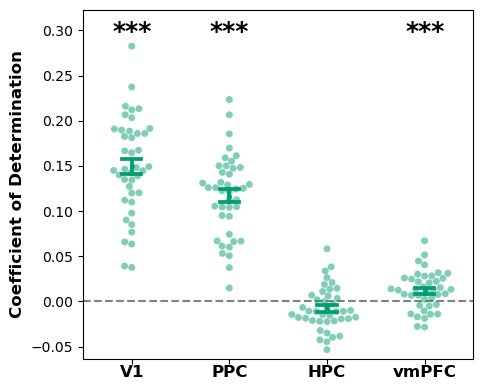

In [31]:
# (1) coefficient of determination
pdf = compo_retrieve_roisubset_df[(compo_retrieve_roisubset_df.analysis=="train2test")&(compo_retrieve_roisubset_df.metricname.isin(['eval_r2']))].copy()
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],ordered=True)
pdf["metricname"] = pd.Categorical(
    pdf.metricname.map({"eval_r2":"Coefficient of Determination"}),
    categories=["Coefficient of Determination"],ordered=True
)
pdf=pdf[pdf.subgroup.isin(["Generalizer"])].copy()

gs = sns.catplot(data=pdf,
            x="roi",y="value",
            hue="subgroup",palette=participantgrouphex,
            kind="point",errorbar="se",alpha=1,dodge=False,capsize=.2,markersize=1.5, linestyle="none",#fill=False,
            #kind="violin",inner="box",fill=False,split=True,gap=0,cut=True,
            #inner_kws = dict(box_width = 15, whis_width=5,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
            height=4,aspect=1.25,sharey=True,
            ).refline(y=0)
gs.map_dataframe(sns.swarmplot,x="roi",y="value",
                #s=4,
                hue="subgroup",palette=participantgrouphex,dodge=False,
                alpha=0.5)


for ax in gs.axes.flatten():
    axdf = pdf.copy()
    ax.set_ylabel("Coefficient of Determination",**def_font_axis_legend_titles)
    ax.set_xlabel('')    
    
    ax.set_xticks(np.arange(len(pdf.roi.cat.categories)),
                  labels=[roi_shortnames[roi] for roi in pdf.roi.cat.categories],
                  **def_font_axis_legend_titles)
    ax.set_ylim(axdf.value.values.min()-0.01,axdf.value.values.max()+0.04)
    plt.setp(ax.get_xticklabels(),
            rotation=0,ha="center",
            **def_font_axis_legend_titles)
    ax.tick_params(axis='x', which='major', pad=1)
            
    for j,(tar,tardf) in enumerate(axdf.groupby(["roi","subgroup"])):
        pval = ttest1samp_equiv_permutation(tardf.value.values,alternative="greater")
        print(f"{roi_shortnames[axdf.roi.values[0]]}  {tar}: mean = {'%.3f' % tardf.value.values.mean()}, p-value = {'%.4f' % pval}")
        
        
        if tardf.value.values.mean()>0:
            ax.text(x=j-.2,y=ax.get_ylim()[1]*.9,
                    s=gen_pval_annot(pval,show_pval=False).replace("p=",""),size=18,fontweight="bold")
        
        ax.tick_params(labelleft=True, labelbottom=True)
        ax.xaxis.label.set_visible(True)
        ax.yaxis.label.set_visible(True)
        ax.spines["top"].set_visible(True)
        ax.spines["right"].set_visible(True)
gs.legend.remove()
gs.tight_layout()
gs.savefig(os.path.join(ROIRSAdir,"finalfigs",f"fig5c.tif"),dpi=300,bbox_inches="tight")






x-axis ('V1_bilateral', 'Generalizer'): mean = 0.112, p-value = 0.00010
x-axis ('PPC_bilateral', 'Generalizer'): mean = 0.092, p-value = 0.00010
x-axis ('vmPFC_bilateral', 'Generalizer'): mean = 0.064, p-value = 0.00010
y-axis ('V1_bilateral', 'Generalizer'): mean = 0.119, p-value = 0.00010
y-axis ('PPC_bilateral', 'Generalizer'): mean = 0.089, p-value = 0.00010
y-axis ('vmPFC_bilateral', 'Generalizer'): mean = 0.063, p-value = 0.00010


d:\miniconda3\envs\piratefmri\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 9.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


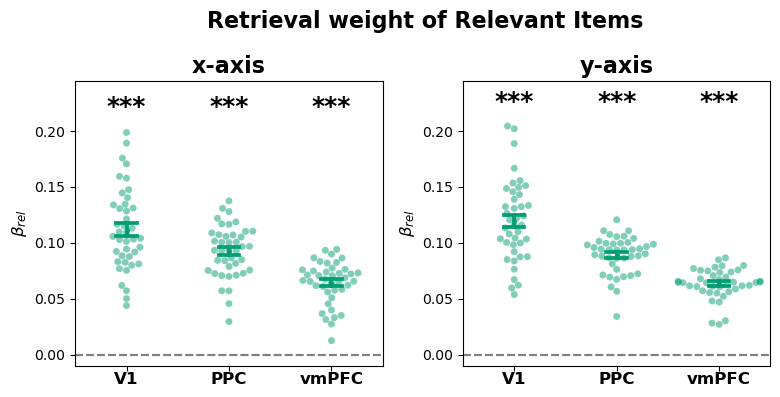

In [32]:
# (2) weight >0
pdf = compo_retrieve_roisubset_df[(compo_retrieve_roisubset_df.analysis=="train2test")&(compo_retrieve_roisubset_df.metricname.isin(['compoweight_x','compoweight_y']))].copy()
pdf = pdf.query("roi in ['V1_bilateral','PPC_bilateral','vmPFC_bilateral']").copy()
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral","vmPFC_bilateral"],ordered=True)

pdf["metricname"] = pd.Categorical(
    pdf.metricname.map({'compoweight_x':'x-axis','compoweight_y':'y-axis'}), # r'$\beta_{rel}-\beta_{irr}$'
    categories=['x-axis','y-axis'],ordered=True
)

gs = sns.catplot(data=pdf,
            x="roi",y="value",col="metricname",
            hue="subgroup",palette=participantgrouphex,
            kind="point",errorbar="se",alpha=1,dodge=False,capsize=.2,markersize=1.5, linestyle="none",#fill=False,
            #kind="violin",inner="box",fill=False,split=True,gap=0,cut=True,
            #inner_kws = dict(box_width = 15, whis_width=5,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
            height=4,aspect=1,sharey=True,
            ).refline(y=0).set_titles('{col_name}',**def_font_subplot_titles)
gs.map_dataframe(sns.swarmplot,x="roi",y="value",
                #s=4,
                hue="subgroup",palette=participantgrouphex,dodge=False,
                alpha=0.5)


for ax in gs.axes.flatten():
    featureax = ax.get_title()
    axdf = pdf[pdf["metricname"]== featureax].copy()
    ax.set_title(featureax,**def_font_subplot_titles)
    ax.set_ylabel(r'$\beta_{rel}$',**def_font_axis_legend_titles)
    ax.set_xlabel('')    
    
    ax.set_xticks(np.arange(len(pdf.roi.cat.categories)),
                  labels=[roi_shortnames[roi] for roi in pdf.roi.cat.categories],
                  **def_font_axis_legend_titles)
    ax.set_ylim(min([axdf.value.values.min()-0.01,-0.01]),axdf.value.values.max()+0.04)
    plt.setp(ax.get_xticklabels(),
            rotation=0,ha="center",
            **def_font_axis_legend_titles)
    ax.tick_params(axis='x', which='major', pad=1)
    ax.axhline(y=0,linestyle="--",color="grey")        
    for j,(tar,tardf) in enumerate(axdf.groupby(["roi","subgroup"])):
        pval = ttest1samp_equiv_permutation(tardf.value.values,alternative="greater")
        print(f"{featureax} {tar}: mean = {'%.3f' % tardf.value.values.mean()}, p-value = {'%.5f' % pval}")
        
        
        if tardf.value.values.mean()>0:
            ax.text(x=j,y=ax.get_ylim()[1]*.9,
                    s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                    ha="center",size=18,fontweight="bold")
        
        ax.tick_params(labelleft=True, labelbottom=True)
        ax.xaxis.label.set_visible(True)
        ax.yaxis.label.set_visible(True)
        ax.spines["top"].set_visible(True)
        ax.spines["right"].set_visible(True)
        
#sns.move_legend(gs, loc="lower center",bbox_to_anchor=(0.4,0.9),ncol=2)
gs.legend.remove()
gs.figure.suptitle("Retrieval weight of Relevant Items",x=.45,**def_font_subplot_titles)
gs.tight_layout()
gs.savefig(os.path.join(ROIRSAdir,"finalfigs",f"figs4a.tif"),dpi=300,bbox_inches="tight")



x-axis ('V1_bilateral', 'Generalizer'): mean = 0.031, p-value = 0.00010
x-axis ('PPC_bilateral', 'Generalizer'): mean = 0.006, p-value = 0.03870
x-axis ('vmPFC_bilateral', 'Generalizer'): mean = 0.006, p-value = 0.01710
y-axis ('V1_bilateral', 'Generalizer'): mean = 0.038, p-value = 0.00010
y-axis ('PPC_bilateral', 'Generalizer'): mean = 0.007, p-value = 0.00310
y-axis ('vmPFC_bilateral', 'Generalizer'): mean = 0.006, p-value = 0.00450


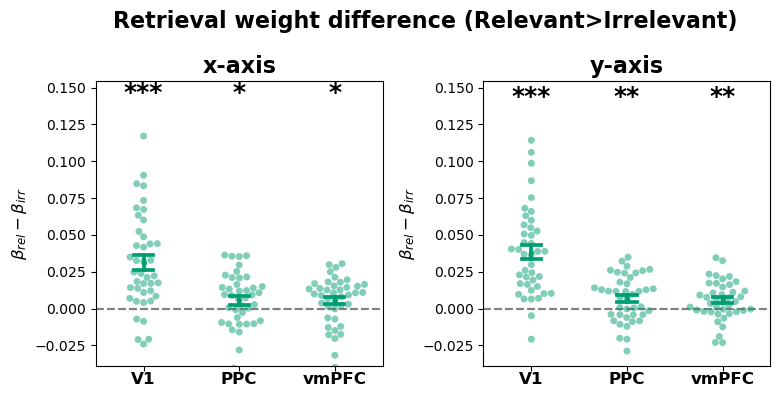

In [33]:
# (3): weight difference
pdf = compo_retrieve_roisubset_df[(compo_retrieve_roisubset_df.analysis=="train2test")&(compo_retrieve_roisubset_df.metricname.isin(['meanweightdiff_x','meanweightdiff_y']))].copy()
pdf = pdf.query("roi in ['V1_bilateral','PPC_bilateral','vmPFC_bilateral']").copy()
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral","vmPFC_bilateral"],ordered=True)

pdf["metricname"] = pd.Categorical(
    pdf.metricname.map({'meanweightdiff_x':'x-axis','meanweightdiff_y':'y-axis'}), # r'$\beta_{rel}-\beta_{irr}$'
    categories=['x-axis','y-axis'],ordered=True
)

gs = sns.catplot(data=pdf,
            x="roi",y="value",col="metricname",
            hue="subgroup",palette=participantgrouphex,
            kind="point",errorbar="se",alpha=1,dodge=False,capsize=.2,markersize=1.5, linestyle="none",#fill=False,
            #kind="violin",inner="box",fill=False,split=True,gap=0,cut=True,
            #inner_kws = dict(box_width = 15, whis_width=5,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
            height=4,aspect=1,sharey=True,
            ).refline(y=0).set_titles('{col_name}',**def_font_subplot_titles)
gs.map_dataframe(sns.swarmplot,x="roi",y="value",
                #s=4,
                hue="subgroup",palette=participantgrouphex,dodge=False,
                alpha=0.5)


for ax in gs.axes.flatten():
    featureax = ax.get_title()
    axdf = pdf[pdf["metricname"]== featureax].copy()
    ax.set_title(featureax,**def_font_subplot_titles)
    ax.set_ylabel( r'$\beta_{rel}-\beta_{irr}$',**def_font_axis_legend_titles)
    ax.set_xlabel('')    
    
    ax.set_xticks(np.arange(len(pdf.roi.cat.categories)),
                  labels=[roi_shortnames[roi] for roi in pdf.roi.cat.categories],
                  **def_font_axis_legend_titles)
    ax.set_ylim(axdf.value.values.min()-0.01,axdf.value.values.max()+0.04)
    plt.setp(ax.get_xticklabels(),
            rotation=0,ha="center",
            **def_font_axis_legend_titles)
    ax.tick_params(axis='x', which='major', pad=1)
    ax.axhline(y=0,linestyle="--",color="grey") 
    for j,(tar,tardf) in enumerate(axdf.groupby(["roi","subgroup"])):
        pval = ttest1samp_equiv_permutation(tardf.value.values,alternative="greater")
        print(f"{featureax} {tar}: mean = {'%.3f' % tardf.value.values.mean()}, p-value = {'%.5f' % pval}")
        
        
        if tardf.value.values.mean()>0:
            ax.text(x=j,y=ax.get_ylim()[1]*.9,
                    s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                    ha="center",size=18,fontweight="bold")
        
        ax.tick_params(labelleft=True, labelbottom=True)
        ax.xaxis.label.set_visible(True)
        ax.yaxis.label.set_visible(True)
        ax.spines["top"].set_visible(True)
        ax.spines["right"].set_visible(True)
#sns.move_legend(gs, loc="lower center",bbox_to_anchor=(0.4,0.9),ncol=2)
gs.figure.suptitle("Retrieval weight difference (Relevant>Irrelevant)",x=.45,**def_font_subplot_titles)
gs.legend.remove()
gs.tight_layout()
gs.savefig(os.path.join(ROIRSAdir,"finalfigs",f"figs4b.tif"),dpi=300,bbox_inches="tight")



### 3. High-D vs Low-D composition
Figure 5d

V1 1
V1 2
V1 3
V1 - ('High',): mean = 0.222, p-value = 0.000
V1 - ('Low',): mean = 0.067, p-value = 0.001
PPC - ('High',): mean = 0.015, p-value = 0.314
PPC - ('Low',): mean = 0.059, p-value = 0.001
vmPFC - ('High',): mean = 0.039, p-value = 0.008
vmPFC - ('Low',): mean = 0.019, p-value = 0.223


d:\miniconda3\envs\piratefmri\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


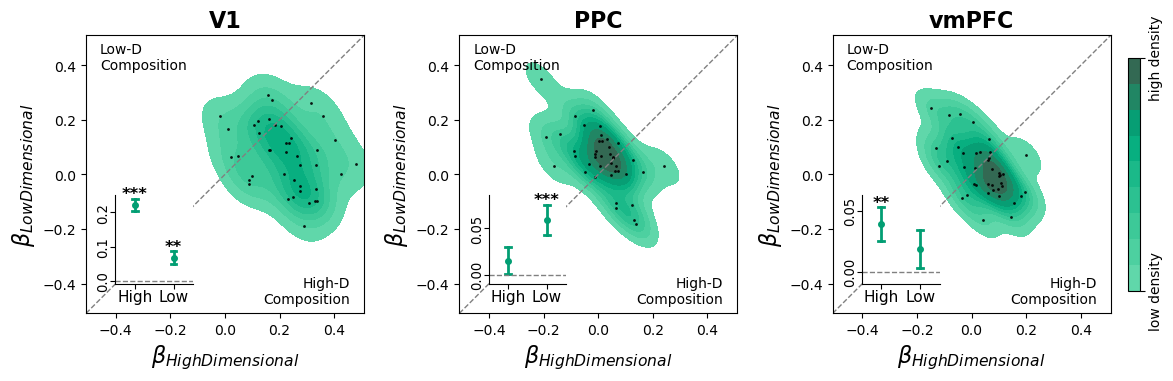

In [34]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# 2D-KDE plots with the two regression coefficients and plot s.e.m. as insect
pdf = compo_retrieve_roisubset_df[(compo_retrieve_roisubset_df.analysis=="train2test")&(compo_retrieve_roisubset_df.metricname.isin(['reg_distmod','reg_percept']))].copy()
pdf = pdf.query("roi in ['V1_bilateral','PPC_bilateral','vmPFC_bilateral']").copy()
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral","vmPFC_bilateral"],ordered=True)

pdf = pdf.query("subgroup=='Generalizer'").copy()

pdf_wide = pdf.pivot_table(index=["roi","subgroup","subid"],columns="metricname",values="value").reset_index()

pdf["metricname_short"] = pd.Categorical(
    pdf.metricname.map({"reg_distmod":r'$\beta_{Low D}$',"reg_percept":r'$\beta_{High D}$'}),
    categories=[r'$\beta_{High D}$',r'$\beta_{Low D}$'],ordered=True
)
pdf["metricname_short"] = pd.Categorical(
    pdf.metricname.map({"reg_distmod":'Low',"reg_percept":'High'}),
    categories=['High','Low'],ordered=True
)

gs = sns.displot(data=pdf_wide, x="reg_percept", y="reg_distmod",
                 color=participantgrouphex["Generalizer"],
                 col="roi",fill=True,alpha=1,
                 cbar=True,common_norm=True,levels=10,
                 cbar_kws={"label": "Density","shrink": 0.7},
                 kind="kde",height=4).set_titles("{col_name}")
gs.map_dataframe(sns.scatterplot,
                 x="reg_percept", y="reg_distmod",
                color="black",#participantgrouphex["Generalizer"],
                alpha=0.9,
                edgecolor=None,linewidth=0,marker="o",
                s=4
                )
        
axlim = np.max(
    [pdf_wide.reg_percept.values.max(),pdf_wide.reg_distmod.values.max(),
     np.abs(pdf_wide.reg_percept.values.min()),np.abs(pdf_wide.reg_distmod.values.min())]
)+.03

gs_insect_axes = []
for ax in gs.axes.flatten():
    roi = ax.title.get_text()
    facet_df = pdf_wide.loc[pdf_wide.roi==roi].copy()

    
    ax.set_aspect(1)

    ax.set_title(f"{roi_shortnames[roi]}",**def_font_subplot_titles)

    ax.set_xlabel(r'$\beta_{High Dimensional}$',fontdict=def_font_subplot_titles)
    ax.set_ylabel(r'$\beta_{Low Dimensional}$',fontdict=def_font_subplot_titles)

    ax.plot([-axlim,axlim], [-axlim,axlim], color='grey', linestyle='--', linewidth=1)

    ax.set_xlim(-axlim,axlim)
    ax.set_ylim(-axlim,axlim)

    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)

    ax.tick_params(labelleft=True, labelbottom=True)
    ax.xaxis.label.set_visible(True)
    ax.yaxis.label.set_visible(True)
    
    ax.text(x=-0.9*axlim, y=0.95*axlim,s="Low-D\nComposition",size=def_font_axis_tick_labels["fontsize"],ha="left",va="top")
    ax.text(x=0.9*axlim, y=-0.95*axlim,s="High-D\nComposition",size=def_font_axis_tick_labels["fontsize"],ha="right",va="bottom")
    
    cbcounter=0
    for cb_ax in gs.figure.axes:
        if cb_ax is not ax and cb_ax.get_ylabel() == 'Density':
            cbcounter+=1
            cmin,cmax = cb_ax.get_ylim()
            # set cbar ticks
            cb_ax.set_yticks([cmin, cmax])
            cb_ax.set_ylabel("")
            cb_ax.set_yticklabels(["low density","high density"],rotation=90,va="center")
            print(ax.title.get_text(),cbcounter)
            if cbcounter<3:
                # remove the colorbar for vmPFC_bilateral
                cb_ax.remove()

    # plot S.E.M. as inset
    inset_ax = inset_axes(ax,
                    width="100%", # width = 30% of parent_bbox
                    height="100%", # height  = 30% of parent_bbox
                    loc='lower left',
                    bbox_to_anchor = (0.08, 0.08, 0.28,0.32), # x, y, width, height
                    bbox_transform=ax.transAxes,
                    axes_kwargs=dict(fc="white") #"none"

    )
    insect_df = pdf.query("roi==@roi").copy()
    sns.pointplot(
        data=insect_df, x="metricname_short",y="value",
        color=participantgrouphex["Generalizer"],
        ax=inset_ax,
        errorbar="se",alpha=1,capsize=.15,dodge=False,markersize=3.5, linestyle="none",lw=2
    )
    inset_ax_max  = np.max([tardf["value"].values.mean()+compute_se(tardf["value"].values) for _,(_,tardf) in enumerate(insect_df.groupby(["metricname_short"]))])
    
    inset_ax.set_ylim(-0.01, inset_ax_max+.01)#max(mean_plus_se_)+.05)
    inset_ax.axhline(y=0, color='grey', linestyle='--', linewidth=1)
    inset_ax.set_xlabel("")
    inset_ax.set_ylabel("")
    inset_ax.set_title("")
    yticks = np.arange(0,inset_ax_max+0.01,0.05)
    if len(yticks)>3:
        yticks = np.arange(0,inset_ax_max+0.01,0.1)
    inset_ax.set_yticks(yticks)
    plt.setp(inset_ax.get_xticklabels(),fontsize=1.1*def_font_axis_tick_labels["fontsize"],fontweight="regular")
    plt.setp(inset_ax.get_yticklabels(),fontsize=.95*def_font_axis_tick_labels["fontsize"],fontweight="regular",
             rotation=90,va="center")
    for j,(tar,tardf) in enumerate(insect_df.groupby(["metricname_short"])):
        
        pval = ttest1samp_equiv_permutation(tardf.value.values)
        print(f"{roi_shortnames[roi]} - {tar}: mean = {'%.3f' % tardf.value.values.mean()}, p-value = {'%.3f' % pval}")
        currsem = tardf.value.values.mean() + compute_se(tardf.value.values)
        inset_ax.text(x=j,y=currsem+.0005,
                s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                size=0.9*13,fontweight="bold",ha="center")        
        
        inset_ax.tick_params(labelleft=True, labelbottom=True,pad=0)
        inset_ax.xaxis.label.set_visible(True)
        inset_ax.yaxis.label.set_visible(True)
        inset_ax.spines["top"].set_visible(False)
        inset_ax.spines["right"].set_visible(False)
    gs_insect_axes.append(inset_ax)

gs.tight_layout()
plt.savefig(os.path.join(ROIRSAdir,"finalfigs","fig5d.tif"),dpi=300,bbox_inches="tight")

# Spatial code shared across task
Plots related to spatial code in treasure hunt and localiser tasks (Figure 6 of the main text). Make sure that the scripts [`rsa_withintask.py`](/scripts/Exp1_fmri/multivariate/rsa_withintask.py), [`rsa_crosstask.py`](/scripts/Exp1_fmri/multivariate/rsa_crosstask.py) and [`decoding_navi2loc.py`](/scripts/Exp1_fmri/multivariate/decoding_navi2loc.py) have been executed before running the plotting scripts in this section.

To get the whole-brain searchlight results shown in supplimentary, run [`Searchlight-HighLowD.py`](Searchlight-HighLowD.py) for first-level analysis and [`secondlevelsearchlightsecondlevelsearchlight.m`](secondlevelsearchlight.m) for second-level analysis. Then, the second-level results can be visualized by running [`visualizesecondlevelresult.py`](visualizesecondlevelresult.py) in  MRIcrogl

## Load results 

In [35]:
# load within-task and crosstask RSA results in ROI
withintask_rsa_df = pd.read_csv(os.path.join(ROIRSAdir,"withintaskrsa","rsa_withintask.csv"))
withintask_rsa_df = withintask_rsa_df[withintask_rsa_df.subid.isin(generalizers)].copy().reset_index(drop=True)
example_stim_df = roi_data["V1_bilateral"][0]["stimdf"].copy()


crosstask_rsa_df = pd.read_csv(os.path.join(ROIRSAdir,"crosstaskrsa","crosstaskrsa_df.csv"))
crosstask_rsa_df = crosstask_rsa_df[crosstask_rsa_df["analysis"].isin(['meancrosstaskpatcorrdiff', 'compare high low D (sym)'])].copy().reset_index(drop=True)
crosstask_rsa_df = crosstask_rsa_df[crosstask_rsa_df.subid.isin(generalizers)].copy().reset_index(drop=True)
crosstask_rdms = load(os.path.join(ROIRSAdir,"crosstaskrsa","crosstask_rdms.pkl"))

# load MDS results
rdm_mds_results = load(os.path.join(ROIRSAdir,"mds_results_rescaled.pkl"))

# load cross-task decoding results
nclocnavi_decoding_res = load(os.path.join(ROIRSAdir,"navi2loc_decoding_results","noncenter_navi2loc_LRdecoding_acc_skf.pkl"))

nclocnavidc_performance_df = nclocnavi_decoding_res["performance"].copy()
nclocnavidc_performance_dfsum = nclocnavidc_performance_df.groupby(["roi","subid","analysis","target"])[["fit_acc","eval_acc"]].mean().reset_index()
nclocnavidc_performance_dfsum["subgroup"] = pd.Categorical(
    ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in nclocnavidc_performance_dfsum["subid"]],
    categories=["Generalizer","nonGeneralizer"],ordered=True
)
nclocnavidc_performance_dfsum["target"] = pd.Categorical(nclocnavidc_performance_dfsum["target"],categories=["stim_x","stim_y"],ordered=True)
nclocnavidc_performance_dfsum[['region','side']] = nclocnavidc_performance_dfsum.roi.str.split("_",expand=True)

nclocnavidc_performance_df["subgroup"] = ["Generalizer" if subid in generalizers else "nonGeneralizer" for subid in nclocnavidc_performance_df["subid"]]
nclocnavidc_performance_df[['region','side']] = nclocnavidc_performance_df.roi.str.split("_",expand=True)

## Stats

In [36]:
# test if correlation coefficients are significantly above zero
yvar, yvartest = "coefficient", "coefficient"


spatial_stats_df = pd.DataFrame()
for a in crosstask_rsa_df["analysis"].unique():
    curr_pdf = crosstask_rsa_df[(crosstask_rsa_df["analysis"]==a)].copy().reset_index(drop=True)
    assert curr_pdf.shape[0]>0, f"No data for {a}"

    curr_pdf.roi = pd.Categorical(curr_pdf.roi,
                                categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],
                                ordered=True)
    for currroi, axdf in curr_pdf.groupby("roi"):
        for j,((mrdm,sg),tardf) in enumerate(axdf.groupby( ["modelrdm",  "subgroup"])):
            pval = ttest1samp_equiv_permutation(tardf[yvar].values)
            print(roi_shortnames[currroi], mrdm, sg,": mean=", np.round(tardf[yvar].mean(),4), ", p=",np.round(pval,4))

            spatial_stats_df = pd.concat([spatial_stats_df,
                                            pd.DataFrame({
                                                "roi":[currroi],
                                                "analysis": a,
                                                "modelrdm":[mrdm],
                                                "subgroup":[sg],
                                                "mu":[tardf[yvar].values.mean()],
                                                "se":[compute_se(tardf[yvar].values)],
                                                "n":[tardf[yvar].count()],
                                                "pval":[pval]
                                            },index=[0])
                                            ],axis=0).reset_index(drop=True)

spatial_stats_df.to_csv(os.path.join(ROIRSAdir,"crosstaskrsa","crosstask_rsa_stat.csv"),index=False)
            

V1 patcorr_SSminSD Generalizer : mean= 0.0284 , p= 0.0002
PPC patcorr_SSminSD Generalizer : mean= 0.004 , p= 0.0076
HPC patcorr_SSminSD Generalizer : mean= 0.0004 , p= 0.8787
vmPFC patcorr_SSminSD Generalizer : mean= 0.0012 , p= 0.3332
V1 high D Generalizer : mean= 0.1868 , p= 0.0002
V1 low D Generalizer : mean= 0.3245 , p= 0.0002
PPC high D Generalizer : mean= 0.1055 , p= 0.0002
PPC low D Generalizer : mean= 0.0695 , p= 0.0162
HPC high D Generalizer : mean= -0.0153 , p= 0.5369
HPC low D Generalizer : mean= -0.0053 , p= 0.8699
vmPFC high D Generalizer : mean= 0.01 , p= 0.7149
vmPFC low D Generalizer : mean= 0.0336 , p= 0.2674


## Plots

### 1. spatial representation
(1) model RDM - figure 6a  
(2) correlation between neural and model RDM - figure 6b  
(3) MDS of V1 pirate position representations- figure 6c

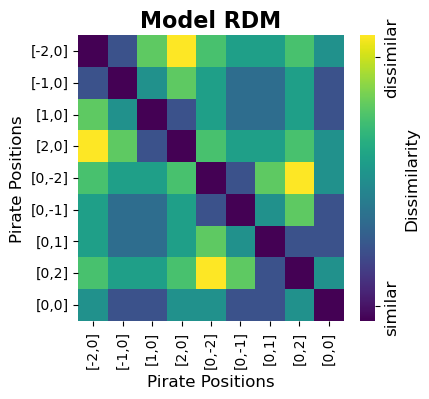

In [37]:
# model RDM figure 6a
example_lzerstim_df = example_stim_df[(example_stim_df.stim_session==4)].copy()
example_lzerstim_df = example_lzerstim_df.sort_values(by=['training_axset', 'training_axlocTL']).reset_index(drop=True)


lzerlowd_rdm = compute_rdm(    
    example_lzerstim_df[["stim_x","stim_y"]].to_numpy(),
    metric="euclidean"
)

fig,axes = plt.subplots(1,1,figsize=(4.4,4.1))
sns.heatmap(
    lzerlowd_rdm,
    ax=axes,
    annot=False,
    xticklabels= [f"[{int(x*2)},{int(y*2)}]" for x,y in example_lzerstim_df[["stim_x","stim_y"]].to_numpy()],
    yticklabels= [f"[{int(x*2)},{int(y*2)}]" for x,y in example_lzerstim_df[["stim_x","stim_y"]].to_numpy()],
    cbar_kws={"label":"Dissimilarity"},
    cmap="viridis"
)    
axes.set_xlabel("Pirate Positions",fontsize=def_font_axis_legend_titles["fontsize"])
axes.set_ylabel("Pirate Positions",fontsize=def_font_axis_legend_titles["fontsize"])

axes.set_title("Model RDM",**def_font_subplot_titles)
cbar = axes.collections[0].colorbar
cbar.set_label(label='Dissimilarity',fontsize=def_font_axis_legend_titles["fontsize"])
cbar.set_ticks([0.1,1.85],labels=["similar","dissimilar"])
for label in cbar.ax.get_yticklabels():
    label.set_rotation(90)
    label.set_ha("left")
    label.set_va("center")
    label.set_size(def_font_axis_legend_titles["fontsize"])
plt.setp(axes.get_xticklabels(),rotation=90,fontsize=def_font_axis_tick_labels["fontsize"])
plt.setp(axes.get_yticklabels(),rotation=0,fontsize=def_font_axis_tick_labels["fontsize"])

fig.tight_layout()
fig.savefig(os.path.join(ROIRSAdir,"finalfigs","fig6a.tif"),dpi=300,bbox_inches="tight")

RSA ('V1',)  mean= 0.7453 , p= 0.0002
RSA ('PPC',)  mean= 0.1162 , p= 0.0016
RSA ('HPC',)  mean= 0.0878 , p= 0.011
RSA ('vmPFC',)  mean= 0.0766 , p= 0.0252


d:\miniconda3\envs\piratefmri\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


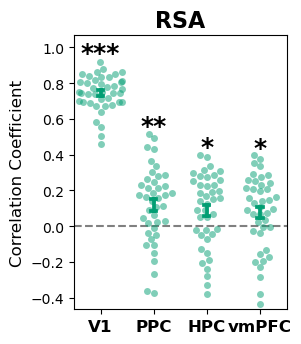

In [38]:
# correlation between neural and model rdm - figure 6b
lzer_compete_fc_df = withintask_rsa_df[(withintask_rsa_df.taskname=='localizer')&(withintask_rsa_df.analysis=='all Cartesian')].copy()
lzer_compete_fc_df.roi = lzer_compete_fc_df.roi.map(roi_shortnames)
lzer_compete_fc_df.roi = pd.Categorical(lzer_compete_fc_df.roi, categories=["V1","PPC","HPC","vmPFC"],ordered=True)


curr_pdf = lzer_compete_fc_df.copy().reset_index(drop=True)
curr_pdf = curr_pdf[curr_pdf.subid.isin(generalizers)].copy()
assert curr_pdf.shape[0]>0, f"No data"
xvar = "roi"
yvar = "coefficient"
atitle = "Pirate Positions"
curr_pdf[xvar] = pd.Categorical(curr_pdf[xvar],ordered=True)

gs = sns.catplot(data=curr_pdf,
            x=xvar,y=yvar,
            kind="point",errorbar="se",capsize=0.1,markersize=0,linestyle="none",
            color = participantgrouphex["Generalizer"],
            #kind="violin",split=True,inner="box",fill=False,gap=0.1,cut=True,
            #inner_kws = dict(box_width = 12, whis_width=4,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
            height=3.7,aspect=.85
            ).refline(y=0).set_titles("{col_name}")
gs.map_dataframe(sns.swarmplot,x=xvar,y=yvar,
                 color = participantgrouphex["Generalizer"],
                alpha=0.5
                )
for ax in gs.axes.flatten():
    ax.set_title("RSA",**def_font_subplot_titles,x=.5)
    ax.set_ylabel("Correlation Coefficient",fontsize=def_font_axis_legend_titles["fontsize"])
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(),**def_font_axis_legend_titles)
    for j,(tar,tardf) in enumerate(curr_pdf.groupby([xvar])):
        pval = ttest1samp_equiv_permutation(tardf[yvar].values)
        print(ax.title.get_text(), tar," mean=", np.round(tardf[yvar].mean(),4), ", p=",np.round(pval,4))
        ax.text(x=j,y=1.01*tardf[yvar].max(),
                s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                size=18,fontweight="bold",
                ha="center")
    ax.set_xlabel("")
    ax.set_ylim(curr_pdf[yvar].min()-.03,curr_pdf[yvar].max()+.15)
    ax.tick_params(labelleft=True, labelbottom=True)
    ax.xaxis.label.set_visible(True)
    ax.yaxis.label.set_visible(True)
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
gs.legend.remove()    
gs.figure.suptitle(f"",y=0.95,x=0.5,**def_font_subplot_titles)
gs.tight_layout(w_pad=3)
gs.savefig(os.path.join(ROIRSAdir,"finalfigs","fig6b.tif"),dpi=300,bbox_inches="tight")

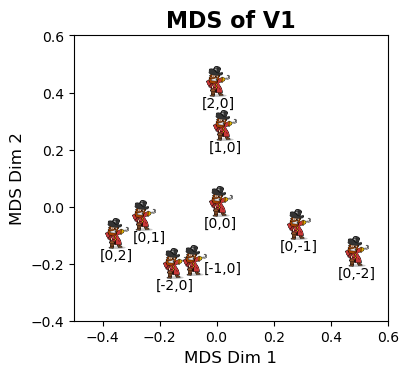

In [39]:
# MDS of V1 - Figure 6c
ssname = "trainloc_all"
roi = "V1_bilateral"
cname = "Combined Cohort"
ncompo = 2

plot_title=f"MDS of V1"

### plot in 2D
roirdm, roimdsdf = rdm_mds_results["aveRDM"][ssname][roi][cname]["G"],rdm_mds_results["MDSres"][f"{ncompo}D"][ssname][roi][cname]["G"]
roimdsdf["stim_name"] = ["%d,%d"%(x,y) for x,y in roimdsdf[["stim_x","stim_y"]].to_numpy()]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

piratepng = plt.imread(os.path.join(svg_folder,"pirate.png"))
range = 2*roimdsdf[['MDS1','MDS2']].to_numpy().max()
imgw, imgh = .5/6, .64/6

for (stim_x, stim_y), group in roimdsdf.groupby(['stim_x', 'stim_y']):
    plotx, ploty = group['MDS1'].values[0], group['MDS2'].values[0]
    piratepng = plt.imread(os.path.join(svg_folder,"pirate.png"))
    ax.imshow(piratepng, extent = (plotx-imgw/2, plotx+imgw/2, ploty+imgh/2, ploty-imgh/2), aspect='auto',origin="lower")
    labs = f"[{int(stim_x)},{int(stim_y)}]"
    if np.logical_and( stim_x == 0,stim_y==1):
        ax.text(plotx+.02, ploty-.05, labs,ha="center",va="top")
    elif np.logical_and(stim_x == -1,stim_y==0):
        ax.text(plotx+.03, ploty, labs,ha="left",va="top")
    else:
        ax.text(plotx, ploty-.05, labs,ha="center",va="top")

# Set plot title and labels
ax.set_title(plot_title,fontdict=def_font_subplot_titles) # - {cname} Generalizers
ax.set_xlabel('MDS Dim 1',fontsize=def_font_axis_legend_titles["fontsize"])
ax.set_ylabel('MDS Dim 2',fontsize=def_font_axis_legend_titles["fontsize"])
plt.setp(ax.get_xticklabels(), fontsize=def_font_axis_tick_labels["fontsize"])
plt.setp(ax.get_yticklabels(), fontsize=def_font_axis_tick_labels["fontsize"])
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-.5, .6)
ax.set_ylim(-.4, .6)
#ax.legend(handles=marker_legend + color_legend, loc='center left', bbox_to_anchor=(0.74, 0.62),fontsize=11)


# Adjust the axis limits to avoid cropping
fig.tight_layout(pad=0.4)
plt.show()
mds_output_dir = os.path.join(ROIRSAdir,"mds_fig")
checkdir(mds_output_dir)
fig.savefig(os.path.join(mds_output_dir,f"{roi}_{ssname}_{cname}_{ncompo}D.png"),bbox_inches='tight',dpi=300)
fig.savefig(os.path.join(ROIRSAdir,"finalfigs","fig6c.tif"),bbox_inches='tight',dpi=300)

### 2. Cross-task representation similarity
(1) model rdm: high and low d - Figure 6d  
(2) empirical rdm: v1 and ppc - Figure 6e  
(3) dissimilarity difference between matching and non-matching pairs  
(4) regression of empirical neural rdm ~ model rdm - figure 6g

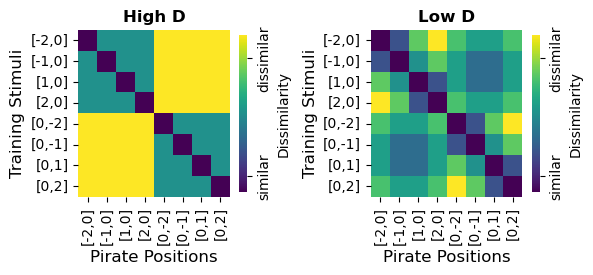

In [40]:
# (1) model rdm: high and low d - Figure 6d  
example_trstim_df = example_stim_df[(example_stim_df.stim_session==0)&(example_stim_df.stim_group==1)].copy()
example_trstim_df = example_trstim_df[~((example_trstim_df.stim_x==0)&(example_trstim_df.stim_y==0))].copy()
#!!  sort them, because we sorted them during the analysis
example_trstim_df = example_trstim_df.sort_values(by=['training_axset', 'training_axlocTL']).reset_index(drop=True)
axticklabels = [f"[{int(x*2)},{int(y*2)}]" for x,y in example_trstim_df[["stim_x","stim_y"]].to_numpy()]

euc_rdm = scipy.spatial.distance.cdist(    
    example_trstim_df[["stim_x","stim_y"]].to_numpy(),
    example_trstim_df[["stim_x","stim_y"]].to_numpy(),
    metric="euclidean"
)
feat_rdm = scipy.spatial.distance.cdist(    
    example_trstim_df[["stim_x","stim_y"]].to_numpy(),
    example_trstim_df[["stim_x","stim_y"]].to_numpy(),
    metric="hamming"
)


fig,axes = plt.subplots(1,2,figsize=(6,3))
sns.heatmap(
        minmax_scale_anyD(euc_rdm),
        ax=axes[1],
        annot=False,
        xticklabels=axticklabels,
        yticklabels=axticklabels,
        cbar_kws={"label":"Dissimilarity","shrink":0.7},
        cmap="viridis"
    )
sns.heatmap(
    minmax_scale_anyD(feat_rdm),
    ax=axes[0],
    annot=False,
    xticklabels=axticklabels,
    yticklabels=axticklabels,
    cbar_kws={"label":"Dissimilarity","shrink":0.7},
    cmap="viridis"
)    
axes[0].set_title("High D",**def_font_axis_legend_titles)
axes[1].set_title("Low D",**def_font_axis_legend_titles)

   

for ax in axes.flatten():
    ax.set_aspect(1.1)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0.1,.85],labels=["similar","dissimilar"])
    for label in cbar.ax.get_yticklabels():
        label.set_rotation(90)
        label.set_ha("left")
        label.set_va("center")
    ax.set_xlabel("Pirate Positions",fontsize=def_font_axis_legend_titles["fontsize"])
    ax.set_ylabel("Training Stimuli",fontsize=def_font_axis_legend_titles["fontsize"])

fig.tight_layout()
fig.savefig(os.path.join(ROIRSAdir,"finalfigs","fig6d.tif"),dpi=300,bbox_inches="tight")



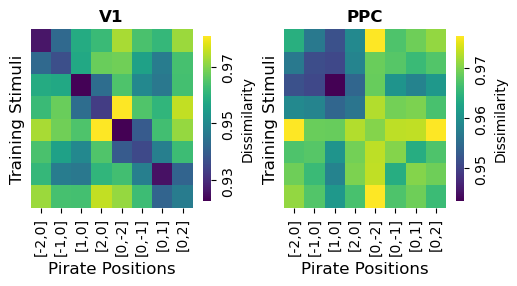

In [41]:
# (2) empirical rdm in V1 and PPC, made to be symmetrical along diagonal - Figrue 6e
fig,axes = plt.subplots(1,2,figsize=(5.3,3))
cbrange = []
for j,roi in enumerate(['V1_bilateral','PPC_bilateral']):
    G_meanrdm = [x for x,subid in zip(crosstask_rdms["symmetric"][roi],subid_list) if subid in generalizers]
    sns.heatmap(
        np.mean(G_meanrdm,axis=0),
        ax=axes[j],
        annot=False,
        xticklabels=axticklabels,
        yticklabels=[],
        cbar_kws={"label":"Dissimilarity","shrink":0.7},
        cmap="viridis"
    )
    # we computed using cdist(navi,lzer), so rows are training stimuli and columns are pirate positions
    
    axes[j].set_title(f"{roi.replace('_bilateral','')}",**def_font_axis_legend_titles)
    cbrange.append([np.mean(G_meanrdm,axis=0).min(),np.mean(G_meanrdm,axis=0).max()])
    
for ax,cr in zip(axes.flatten(),cbrange):
    ax.set_aspect(1.1)
    ax.set_ylabel("Training Stimuli",fontsize=def_font_axis_legend_titles["fontsize"])
    ax.set_xlabel("Pirate Positions",fontsize=def_font_axis_legend_titles["fontsize"])
    cbar = ax.collections[0].colorbar
    ticks = np.round(np.linspace(cr[0]+0.01,cr[1]-0.01,num=3),2)
    cbar.set_ticks(ticks)
    for label in cbar.ax.get_yticklabels():
        label.set_rotation(90)
        label.set_ha("left")
        label.set_va("center")
fig.tight_layout(w_pad=0.5)

fig.savefig(os.path.join(ROIRSAdir,"finalfigs","fig6e.tif"),dpi=300,bbox_inches="tight")

 ('V1_bilateral',)  mean= -0.0284 , p= 0.0002
 ('PPC_bilateral',)  mean= -0.004 , p= 0.0076
 ('HPC_bilateral',)  mean= -0.0004 , p= 0.8787
 ('vmPFC_bilateral',)  mean= -0.0012 , p= 0.3332


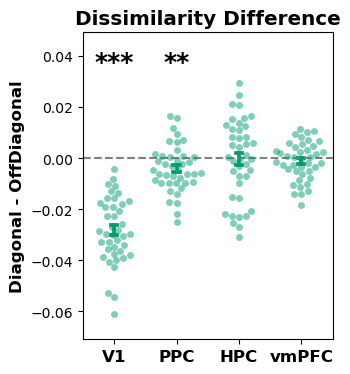

In [42]:
# (3) Dissimilarity Difference - Figure 6f
a = 'meancrosstaskpatcorrdiff'
xvar, gvar, yvar, yvartest = "roi",  "subgroup", "coefficient", "coefficient"
colvar, colnamedict = "roi", roi_shortnames
split_plot_var = "analysis"
analysis_name_dict = dict(zip(
    ['meancrosstaskpatcorrdiff',
     'compare high low D (sym)'],
    ['Corresponding - nonCorresponding',
     'compare high low D']   
))

curr_pdf = crosstask_rsa_df[(crosstask_rsa_df[split_plot_var]==a)].copy().reset_index(drop=True)
curr_pdf = curr_pdf[curr_pdf.subid.isin(generalizers)].copy()
curr_pdf[yvar] = -curr_pdf[yvar]  # we want to plot the difference between corresponding and non-corresponding, so we invert the sign
assert curr_pdf.shape[0]>0, f"No data for {a}"
atitle = analysis_name_dict[a]
curr_pdf.roi = pd.Categorical(curr_pdf.roi,
                            categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],
                            ordered=True)
gs = sns.catplot(data=curr_pdf,
            x=xvar,y=yvar,
            kind="point",errorbar="se",capsize=0.1,markersize=0,linestyle="none",
            color = participantgrouphex["Generalizer"],
            #kind="violin",split=True,inner="box",fill=False,gap=0.1,cut=True,
            #inner_kws = dict(box_width = 12, whis_width=4,marker=".",markeredgecolor="black",markerfacecolor="black",alpha=0.9),
            height=4,aspect=.9
            ).refline(y=0).set_titles("{col_name}")
gs.map_dataframe(sns.swarmplot,x=xvar,y=yvar,
                 color = participantgrouphex["Generalizer"],
                alpha=0.5
                )
ax = gs.axes.flatten()[0]
for j,(tar,tardf) in enumerate(curr_pdf.groupby([xvar])):
    
    pval = ttest1samp_equiv_permutation(tardf[yvar].values)
    print(ax.title.get_text(), tar," mean=", np.round(tardf[yvar].mean(),4), ", p=",np.round(pval,4))
    ax.text(x=j,y=0.035,
            s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
            size=18,fontweight="bold",
            ha="center")
ax.set_ylim([curr_pdf[yvar].min()-0.01,curr_pdf[yvar].max()+0.02])
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.set_xticks(ticks=[0,1,2,3],labels=[roi_shortnames[x] for x in curr_pdf.roi.cat.categories],rotation=0,ha="center",**def_font_axis_legend_titles)
ax.set_ylabel("Diagonal - OffDiagonal",**def_font_axis_legend_titles)#
ax.set_xlabel("")
ax.set_title("Dissimilarity Difference",fontsize=def_font_subplot_titles["fontsize"]*0.9,fontweight="bold")
gs.legend.remove()    
gs.figure.suptitle(f"",y=0.95,x=0.5,**def_font_subplot_titles)
gs.tight_layout()
gs.savefig(os.path.join(ROIRSAdir,"finalfigs","fig6f.tif"),dpi=300,bbox_inches="tight")

V1 ('high D',)  mean= 0.1868 , p= 0.0002
V1 ('low D',)  mean= 0.3245 , p= 0.0002
PPC ('high D',)  mean= 0.1055 , p= 0.0002
PPC ('low D',)  mean= 0.0695 , p= 0.0162


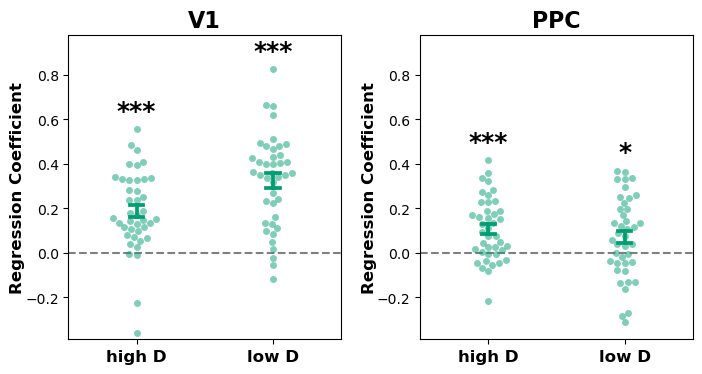

In [43]:
# (4) regression of empirical neural rdm ~ model rdm - figure 6g
a = 'compare high low D (sym)'
xvar, gvar, yvar, yvartest = "modelrdm",  "subgroup", "coefficient", "coefficient"
colvar, colnamedict = "roi", roi_shortnames
split_plot_var = "analysis"
analysis_name_dict = dict(zip(
    ['meancrosstaskpatcorrdiff',
     'compare high low D (sym)'],
    ['Corresponding - nonCorresponding',
     'compare high low D']   
))


curr_pdf = crosstask_rsa_df[(crosstask_rsa_df[split_plot_var]==a)].copy().reset_index(drop=True)
curr_pdf = curr_pdf[curr_pdf.subid.isin(generalizers)].copy()
curr_pdf = curr_pdf[curr_pdf.roi.isin(['V1_bilateral','PPC_bilateral'])].copy().reset_index(drop=True)
assert curr_pdf.shape[0]>0, f"No data for {a}"
atitle = analysis_name_dict[a]
curr_pdf.roi = pd.Categorical(curr_pdf.roi,
                            categories=["V1_bilateral","PPC_bilateral"],
                            ordered=True)
gs = sns.catplot(data=curr_pdf,
            x=xvar,y=yvar,
            kind="point",errorbar="se",capsize=0.1,markersize=0,linestyle="none",
            col="roi",
            color = participantgrouphex["Generalizer"],
            height=4,aspect=.9
            ).refline(y=0).set_titles("{col_name}")
gs.map_dataframe(sns.swarmplot,x=xvar,y=yvar,
                 color = participantgrouphex["Generalizer"],
                alpha=0.5
                )
for ax in gs.axes.flatten():
    axdf = curr_pdf[curr_pdf.roi==ax.title.get_text()]
    ax.set_title(roi_shortnames[axdf.roi.values[0]],**def_font_subplot_titles)
    ax.set_ylabel("Regression Coefficient",labelpad=0,**def_font_axis_legend_titles)
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(),**def_font_axis_legend_titles)
    for j,(tar,tardf) in enumerate(axdf.groupby([xvar])):
        
        pval = ttest1samp_equiv_permutation(tardf[yvar].values)
        print(ax.title.get_text(), tar," mean=", np.round(tardf[yvar].mean(),4), ", p=",np.round(pval,4))
        ax.text(x=j,y=0.05+tardf[yvar].max(),
                s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                size=18,fontweight="bold",
                ha="center")
    ax.set_xlabel("")
    ax.set_ylim(curr_pdf[yvar].min()-.03,curr_pdf[yvar].max()+.15)

    ax.tick_params(labelleft=True, labelbottom=True)
    ax.xaxis.label.set_visible(True)
    ax.yaxis.label.set_visible(True)
    ax.spines["top"].set_visible(True)
    ax.spines["right"].set_visible(True)
gs.legend.remove()    
gs.figure.suptitle(f"",y=0.95,x=0.5,**def_font_subplot_titles)
gs.tight_layout(w_pad=1.5)

gs.savefig(os.path.join(ROIRSAdir,"finalfigs","fig6g.tif"),dpi=300,bbox_inches="tight")


### 3. Cross Task Decoding Data  
(1) V1, decoder fitted on representations of test stimuli in treasure hunt task, evalutaed in localiser task - Figure 6h  
(2) all roi, fitted in training or test stimuli in treasure hunt task, evaluated in localiser task - Figure S5cd 

V1 - x-axis: mean = 0.522, p-value = 0.0002
V1 - y-axis: mean = 0.536, p-value = 0.0002
PPC - x-axis: mean = 0.243, p-value = 0.8519
PPC - y-axis: mean = 0.273, p-value = 0.5043


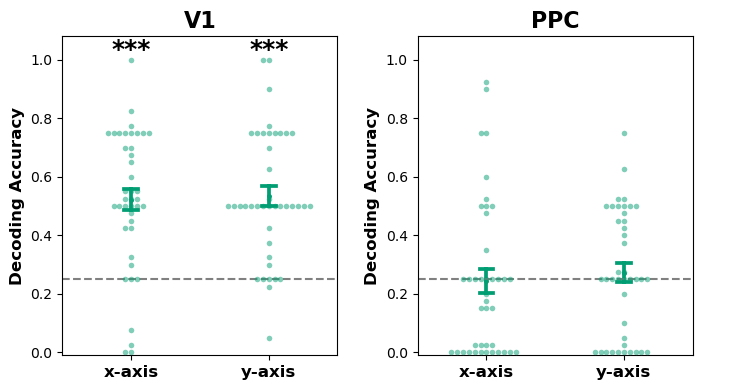

In [44]:
# (1) Figure 6h
nclocnavidc_performance_dfsum["eval_acc_above_chance"] = nclocnavidc_performance_dfsum.eval_acc - 0.25

nclocnavidc_performance_dfsum["region"] = pd.Categorical(nclocnavidc_performance_dfsum["region"],ordered=True)

pdf = nclocnavidc_performance_dfsum[(nclocnavidc_performance_dfsum.analysis=="test2loc")].copy()

pdf = pdf.query("roi in ['V1_bilateral','PPC_bilateral']").copy()
pdf = pdf[pdf.subid.isin(generalizers)].copy()
pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral"],ordered=True)

pdf["target"] = pd.Categorical(
    pdf.target.map({"stim_x":"x-axis","stim_y":"y-axis"}),
    categories=["x-axis","y-axis"],ordered=True
)

xvar, yvar, yvartest = "target", "eval_acc", "eval_acc_above_chance"
colvar, colnamedict = "roi", roi_shortnames
xlabel, ylabel = "Decoding Target", "Decoding Accuracy"
gs = sns.catplot(data=pdf,
            x=xvar,y=yvar,
            col=colvar,
            kind="point",errorbar="se",alpha=1,capsize=.1,markersize=1.5, linestyle="none",#fill=False,
            color=participantgrouphex["Generalizer"],
            height=4,aspect=0.9
            ).refline(y=0.25).set_titles("{col_name}")
gs.map_dataframe(sns.swarmplot,x=xvar,y=yvar,
                alpha=0.5,s=4,
                color=participantgrouphex["Generalizer"],
                )


for ax in gs.axes.flatten():
    axdf = pdf[pdf[colvar]==ax.title.get_text()]
    ax.set_title(colnamedict[axdf[colvar].values[0]],**def_font_subplot_titles)

    ax.set_ylim(pdf[yvar].values.min()-0.01,pdf[yvar].values.max()+0.08)
    ax.set_ylabel("Decoding Accuracy",**def_font_axis_legend_titles)
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(),**def_font_axis_legend_titles)
    for j,(xval,xvaldf) in enumerate(axdf.groupby(xvar)):
        pval = ttest1samp_equiv_permutation(xvaldf[yvartest].values)
        print(f"{colnamedict[axdf[colvar].values[0]]} - {xval}: mean = {'%.3f' % xvaldf[yvar].values.mean()}, p-value = {'%.4f' % pval}")
        
        ax.text(x=j,y=1.01*pdf[yvar].max(),
                s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                size=18,fontweight="bold",ha="center")
        
        
        ax.tick_params(labelleft=True, labelbottom=True)
        ax.xaxis.label.set_visible(True)
        ax.yaxis.label.set_visible(True)
        ax.spines["top"].set_visible(True)
        ax.spines["right"].set_visible(True)

gs.tight_layout(w_pad=2)
gs.savefig(os.path.join(ROIRSAdir,"finalfigs","fig6h.tif"),dpi=300,bbox_inches="tight")

(656, 10)


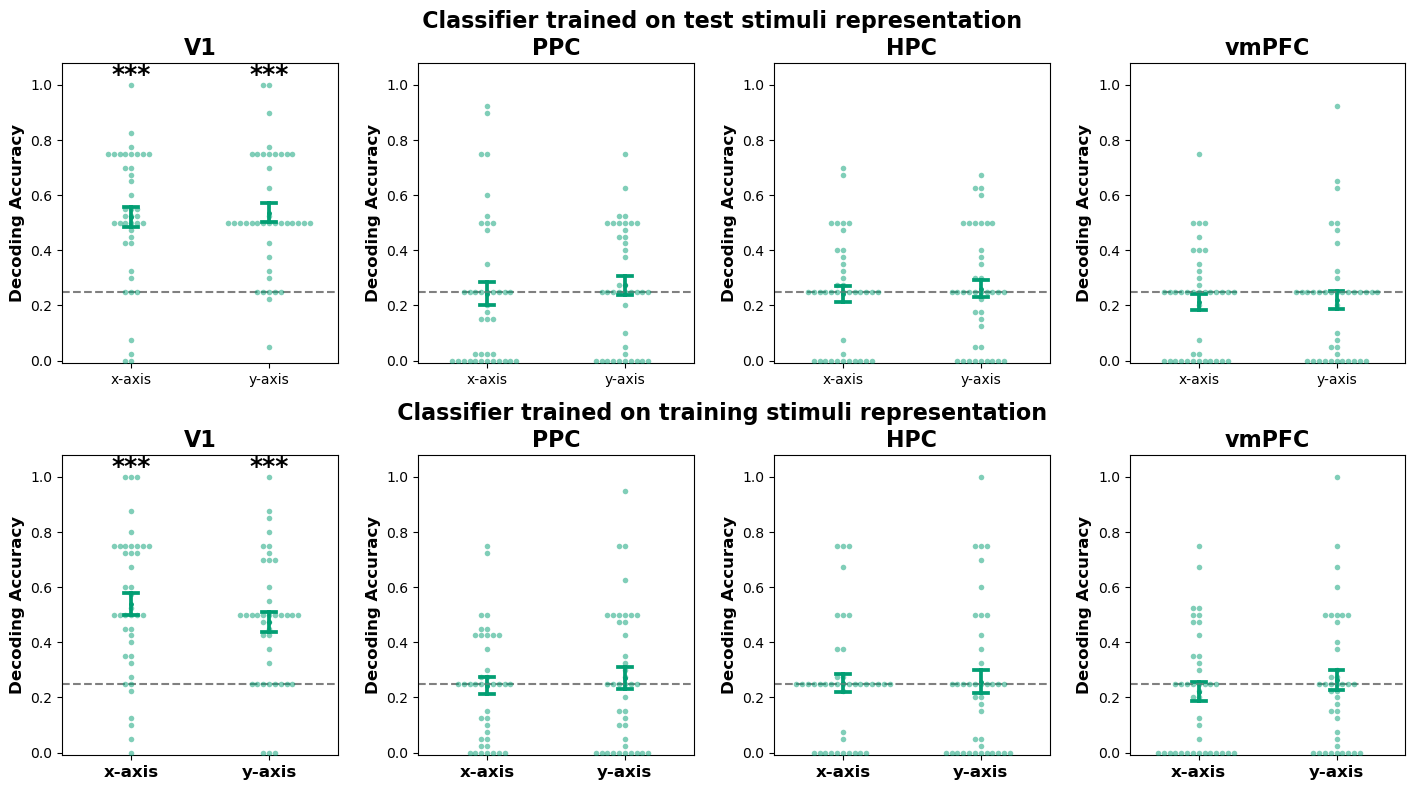

In [45]:
# (2) Figure S5 c-d
nclocnavidc_performance_dfsum["eval_acc_above_chance"] = nclocnavidc_performance_dfsum.eval_acc - 0.25

nclocnavidc_performance_dfsum["region"] = pd.Categorical(nclocnavidc_performance_dfsum["region"],ordered=True)

pdf = nclocnavidc_performance_dfsum.copy()

pdf.roi = pd.Categorical(pdf.roi, categories=["V1_bilateral","PPC_bilateral","HPC_bilateral","vmPFC_bilateral"],ordered=True)
pdf = pdf[pdf.subid.isin(generalizers)].copy()
pdf["target"] = pd.Categorical(
    pdf.target.map({"stim_x":"x-axis","stim_y":"y-axis"}),
    categories=["x-axis","y-axis"],ordered=True
)
print(pdf.shape)

xvar, groupvar, yvar, yvartest = "target", "subgroup", "eval_acc", "eval_acc_above_chance"
colvar, colnamedict = "roi", roi_shortnames
xlabel, ylabel = "Decoding Target", "Decoding Accuracy"
gs = sns.catplot(data=pdf,
            x=xvar,y=yvar,
            col=colvar,
            row="analysis",
            color=participantgrouphex["Generalizer"],
            kind="point",errorbar="se",alpha=1,capsize=.1,markersize=1.5, linestyle="none",
            height=4,aspect=0.9
            ).refline(y=0.25).set_titles("{row_name}..{col_name}")
gs.map_dataframe(sns.swarmplot,x=xvar,y=yvar,
                color=participantgrouphex["Generalizer"],
                alpha=0.5,s=4
                )


for ax in gs.axes.flatten():
    rowval,colval = ax.title.get_text().split("..")
    axdf = pdf[(pdf[colvar]==colval)&(pdf["analysis"]==rowval)].copy()
    if colval == "PPC_bilateral":
        ananame = f'                                           Classifier trained on {rowval.replace("2loc","").replace("train","training")} stimuli representation'
        ax.set_title(f"{ananame}\n{colnamedict[colval]}",x=0.5,**def_font_subplot_titles)
    else:
        ax.set_title(colnamedict[colval],**def_font_subplot_titles)

    ax.set_ylim(pdf[yvar].values.min()-0.01,pdf[yvar].values.max()+0.08)
    ax.set_ylabel("Decoding Accuracy",**def_font_axis_legend_titles)
    ax.set_xlabel("")
    plt.setp(ax.get_xticklabels(),**def_font_axis_legend_titles)
    for j,(xval,xvaldf) in enumerate(axdf.groupby(xvar)):
            pval = ttest1samp_equiv_permutation(xvaldf[yvartest].values)
            if xvaldf[yvartest].values.mean()>0:
                ax.text(x=j,y=1.01*pdf[yvar].max(),
                        s=gen_pval_annot(pval,show_pval=False).replace("p=",""),
                        size=18,fontweight="bold",ha="center")
            
            
            ax.tick_params(labelleft=True, labelbottom=True)
            ax.xaxis.label.set_visible(True)
            ax.yaxis.label.set_visible(True)
            ax.spines["top"].set_visible(True)
            ax.spines["right"].set_visible(True)
gs.legend.remove()
gs.tight_layout(w_pad=2)
gs.savefig(os.path.join(ROIRSAdir,"finalfigs","figS5cd.tif"),dpi=300,bbox_inches="tight")

# Schematic Summary
These code chunks plot the anatomical masks used in this study in the glass brain

In [134]:
# first we upsample the mask amd smooth it so that it looks prettier on the glass brain display
import os
import numpy as np
import nibabel as nib
from nilearn.image import resample_img, resample_to_img, smooth_img, math_img
from nilearn import datasets
from nibabel.affines import apply_affine
from scipy.ndimage import binary_closing, binary_dilation

def build_target_affine_and_shape(source_img, voxel_size_mm):
    """
    Build a target affine and shape so that the target grid (with isotropic voxel_size_mm)
    covers the source_img bounding box exactly in world coordinates.
    Returns (target_affine, target_shape).
    """
    # source affine and shape
    A = source_img.affine
    shape = source_img.shape

    # make array of the 8 corners in voxel coordinates
    corners_ijk = np.array([[i, j, k]
                            for i in (0, shape[0]-1)
                            for j in (0, shape[1]-1)
                            for k in (0, shape[2]-1)], dtype=float)
    # convert to world coords
    corners_xyz = apply_affine(A, corners_ijk)

    # bounding box in world space
    bb_min = corners_xyz.min(axis=0)
    bb_max = corners_xyz.max(axis=0)

    # Add a small epsilon margin (optional)
    eps = 1e-6
    bb_min = bb_min - eps
    bb_max = bb_max + eps

    # compute target shape: how many voxels fit along each axis
    extents = bb_max - bb_min  # physical size in mm
    target_shape = np.ceil(extents / voxel_size_mm).astype(int)

    # build target affine: diagonal with voxel_size and translation = bb_min
    # Note: we assume axis-aligned voxels (no rotation). If your source affine has rotation,
    # this will produce an axis-aligned target grid. That's what you want for isotropic upsample.
    target_affine = np.diag([voxel_size_mm, voxel_size_mm, voxel_size_mm, 1.0])
    target_affine[:3, 3] = bb_min  # place origin at bb_min

    return target_affine, tuple(target_shape)


# Load your ROIs as NIfTI images
roi_imgs = dict(zip(roi_shortnames.values(),
                 [nib.load(os.path.join(ROIRSAdir, f"{r}.nii")) for r in roi_shortnames.keys()]))

roi_imgs_display = {}
display_voxel_size = .5  # mm

# Get MNI152 brain mask at desired resolution (1 mm here)
mni_mask_img = datasets.load_mni152_brain_mask(resolution=display_voxel_size)
# resample masks
for roi_name, roi_img in roi_imgs.items():
    # If roi_img is a filepath string, load it
    if isinstance(roi_img, str):
        img = nib.load(roi_img)
    else:
        img = roi_img

    # resample with linear interpolation # ignore warning, we are only using it for display
    roi_resampled = resample_img(
        img,
        target_affine=mni_mask_img.affine,
        target_shape=mni_mask_img.shape,
        interpolation='continuous'
    )
    assert np.unique(roi_resampled.get_fdata()).size>1, f"empty mask after resampling"

    # Slight smoothing for display only    
    roi_smoothed = smooth_img(roi_resampled, fwhm=1.)
    assert np.unique(roi_smoothed.get_fdata()).size>1, f"empty mask after smoothing"
    # Clip ROI to brain mask
    roi_clipped = math_img("img1 * img2", img1=roi_smoothed, img2=mni_mask_img)
    assert np.unique(roi_clipped.get_fdata()).size>1, f"empty mask after clipping"
    
    # save for plotting
    roi_imgs_display[roi_name] = roi_clipped


d:\miniconda3\envs\piratefmri\lib\site-packages\nilearn\image\resampling.py:294: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
d:\miniconda3\envs\piratefmri\lib\site-packages\nilearn\image\resampling.py:294: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
d:\miniconda3\envs\piratefmri\lib\site-packages\nilearn\image\resampling.py:294: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(
d:\miniconda3\envs\piratefmri\lib\site-packages\nilearn\image\resampling.py:294: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexp

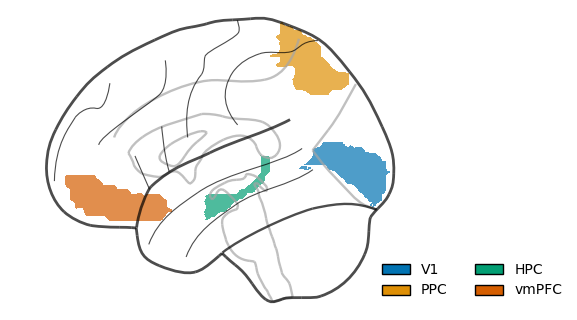

In [135]:
# plot the masks of ROIs on the same glass brain with different colours

from nilearn import plotting, image
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch


fig = plt.figure(figsize=(4.2,3))
# Colors for each ROI
roi_names = ["V1","PPC","HPC","vmPFC"]
cmap_base = sns.color_palette("colorblind", n_colors=len(roi_names))
roi_colors = {roi: cmap_base[i] for i, roi in enumerate(roi_names)}

blank_img = nib.Nifti1Image(np.zeros((91, 109, 91), dtype=np.float32), affine=np.eye(4))
# Create empty glass brain display
display = plotting.plot_glass_brain(None, display_mode='l', colorbar=False,figure=fig,background_img=None, brain_color=(1, 1, 1, 1) )


# Add each ROI to the glass brain with a single-color cmap
for roi_name, roi_img in roi_imgs.items():
    single_color_cmap = ListedColormap([roi_colors[roi_name]])
    display.add_overlay(roi_imgs_display[roi_name], cmap=single_color_cmap, alpha=0.7)

# Add legend
legend_elements = [
    Patch(facecolor=roi_colors[roi], edgecolor='black', label=roi)
    for roi in roi_names
]
fig.legend(handles=legend_elements, loc='lower center',
           bbox_to_anchor=(1.1, 0),
           ncol=2, frameon=False)

plt.show()

fig.savefig(os.path.join(ROIRSAdir,"finalfigs","SchematicSummary_ROIs.tif"),bbox_inches="tight",dpi=300)

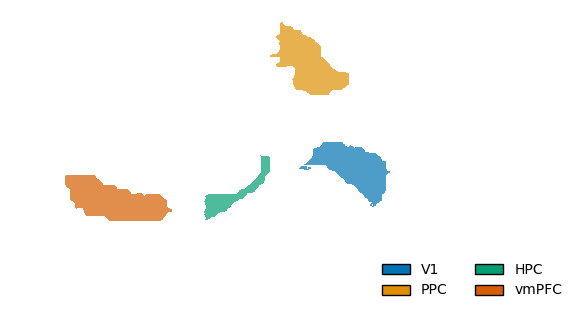

In [138]:
# plot the masks of ROIs on the same glass brain with different colours

from nilearn import plotting, image
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch


fig = plt.figure(figsize=(4.2,3))
# Colors for each ROI
roi_names = ["V1","PPC","HPC","vmPFC"]
cmap_base = sns.color_palette("colorblind", n_colors=len(roi_names))
roi_colors = {roi: cmap_base[i] for i, roi in enumerate(roi_names)}

blank_img = nib.Nifti1Image(np.zeros((91, 109, 91), dtype=np.float32), affine=np.eye(4))
# Create empty glass brain display
display = plotting.plot_glass_brain(None, display_mode='l', colorbar=False,figure=fig,background_img=None, brain_color=(0,0,0, 0),alpha=0 )


# Add each ROI to the glass brain with a single-color cmap
for roi_name, roi_img in roi_imgs.items():
    single_color_cmap = ListedColormap([roi_colors[roi_name]])
    display.add_overlay(roi_imgs_display[roi_name], cmap=single_color_cmap, alpha=0.7)

# Add legend
legend_elements = [
    Patch(facecolor=roi_colors[roi], edgecolor='black', label=roi)
    for roi in roi_names
]
fig.legend(handles=legend_elements, loc='lower center',
           bbox_to_anchor=(1.1, 0),
           ncol=2, frameon=False)

plt.show()

fig.savefig(os.path.join(ROIRSAdir,"finalfigs","SchematicSummary_ROIsonly.tif"),bbox_inches="tight",dpi=300)

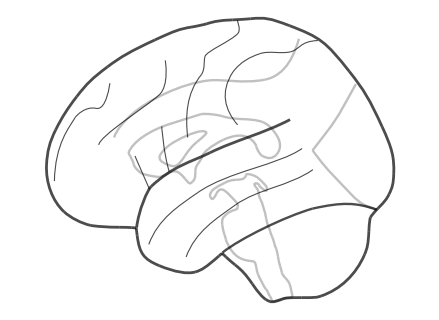

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nib
import seaborn as sns

fig = plt.figure(figsize=(4.2,3))

# Colors for each ROI
roi_names = ["V1","PPC","HPC","vmPFC"]
cmap_base = sns.color_palette("colorblind", n_colors=len(roi_names))
roi_colors = {roi: cmap_base[i] for i, roi in enumerate(roi_names)}

# Create empty glass brain display
display = plotting.plot_glass_brain(
    None,
    display_mode='l',
    colorbar=False,
    figure=fig,
    background_img=None,
    black_bg=False
)

fig.savefig(os.path.join(ROIRSAdir,"finalfigs","SchematicSummary_emptyglassbrain.tif"),bbox_inches="tight",dpi=300)
